<a href="https://colab.research.google.com/github/Carlos1971Salud/2021-Dengue-Fever-Prediction-Time-Series/blob/master/PASO_2_SINTAXIS_PRONOISTICO_IQUITOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [192]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv

In [193]:
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    plt.figure(figsize=(10, 6))
    if type(y) is tuple:
        for y_curr in y:
            plt.plot(x[start:end], y_curr[start:end], format)
    else:
        plt.plot(x[start:end], y[start:end], format)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if legend:
        plt.legend(legend)
    plt.title(title)
    plt.grid(True)

**2. Get DATA**
Take Data from Upstream (Local, Gdrive, Github, etc).

**Data Visualize**

In [194]:
import pandas as pd

# Load the dataset
data = pd.read_csv('/content/modelo_iquitos_dengue.csv', index_col='fecha', parse_dates=True)

data = data.drop(columns=['month'])

# Display the first few rows
display(data.head())

CASOS  tmean  tmax  tmin  humr   ptot
fecha                                            
2016-01-07     12   26.9  31.1  24.3  89.8   59.9
2016-01-14     14   28.8  33.2  25.6  82.1    6.6
2016-01-21      6   27.0  30.5  24.9  89.6   37.6
2016-01-28     20   27.5  31.9  24.9  86.8   46.4
2016-02-04     32   26.8  30.9  24.2  88.9  108.2

In [195]:
time = data.index
series = data['CASOS']

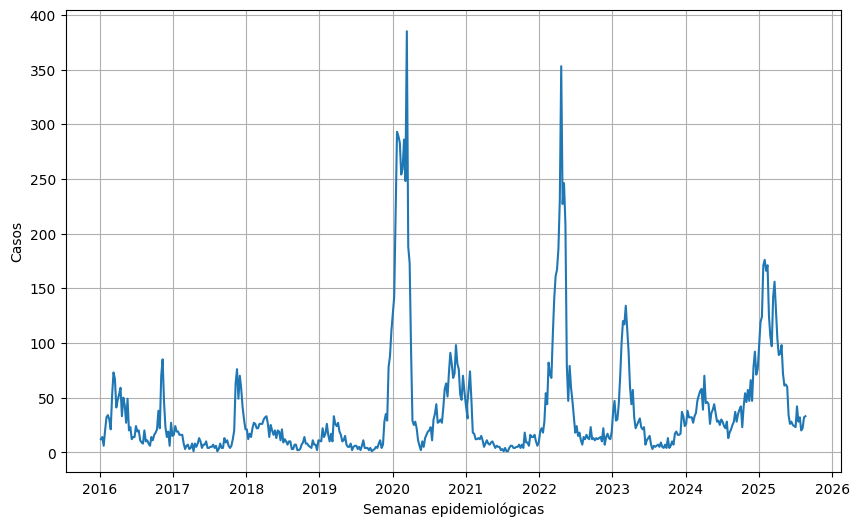

In [196]:
plot_series(time, series, xlabel='Semanas epidemiológicas', ylabel='Casos')

**3. Data Prerocessing**

Analysis and Cleaning Data -> Extract, Transform, Load.

Split Data

In [197]:
split_time = int(len(time)*0.7)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

**Prepare Features and Labels**

In [198]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset
window_size = 7
batch_size = 32
shuffle_buffer_size = 1000
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

**4. Model Architechture**

Using library from Scikit-learn, Tensorflow(?).

**RNN Model**

In [199]:
model_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,833 (65.75 KB)

 Trainable params: 16,833 (65.75 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM Model**

In [200]:
model_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,369 (259.25 KB)

 Trainable params: 66,369 (259.25 KB)

 Non-trainable params: 0 (0.00 B)

**GRU Model**

In [201]:
model_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,241 (196.25 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

**RNN-LSTM Model**

In [202]:
model_RNN_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_LSTM.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_2 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_3 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

**RNN-GRU Model**

In [203]:
model_RNN_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.SimpleRNN(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_RNN_GRU.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 7, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_4 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM-RNN**

In [204]:
model_LSTM_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_RNN.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_4 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_5 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,601 (162.50 KB)

 Trainable params: 41,601 (162.50 KB)

 Non-trainable params: 0 (0.00 B)

**LSTM-GRU Model**

In [205]:
model_LSTM_GRU = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.LSTM(64, return_sequences=True),
tf.keras.layers.GRU(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_LSTM_GRU.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_6 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 7, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_6 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

**GRU-RNN Model**

In [206]:
model_GRU_RNN = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
                       input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.SimpleRNN(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_RNN.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_7 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_4 (GRU)                     │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_7 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,537 (131.00 KB)

 Trainable params: 33,537 (131.00 KB)

 Non-trainable params: 0 (0.00 B)

**GRU-LSTM Model**

In [207]:
model_GRU_LSTM = tf.keras.models.Sequential([
tf.keras.layers.Conv1D(filters=64, kernel_size=3,
strides=1,
activation="relu",
padding='causal',
input_shape=[window_size, 1]),
tf.keras.layers.GRU(64, return_sequences=True),
tf.keras.layers.LSTM(64),
tf.keras.layers.Dense(1),
tf.keras.layers.Lambda(lambda x: x * 100)
])
model_GRU_LSTM .summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 7, 64)          │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 7, 64)          │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_8 (Lambda)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,305 (227.75 KB)

 Trainable params: 58,305 (227.75 KB)

 Non-trainable params: 0 (0.00 B)

**5. Model Training**

In [208]:
tf.keras.backend.clear_session()
learning_rate = 8e-7

In [209]:
optimizer_RNN = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN,
metrics=["mae", "mse", "mape"])
history_RNN = model_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 74.9776 - mae: 75.4776 - mape: 859.0132 - mse: 7973.9712
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 31.4433 - mae: 31.9411 - mape: 345.0237 - mse: 2509.9639
Epoch 3/100
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 37.5887 - mae: 38.0883 - mape: 367.9470 - mse: 2610.3633

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 35.5843 - mae: 36.0820 - mape: 293.6208 - mse: 2730.5046
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 27.5454 - mae: 28.0372 - mape: 209.8982 - mse: 3021.8198
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 28.4956 - mae: 28.9894 - mape: 184.3037 - mse: 3400.7942
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 22.3359 - mae: 22.8323 - mape: 126.4371 - mse: 2251.7571
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23.5223 - mae: 24.0152 - mape: 119.1845 - mse: 2737.9626
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 23.9772 - mae: 24.4704 - mape: 125.2539 - mse: 3148.3386
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 21.1022 - mae: 21.5950 - mape: 121.8430 - mse: 2271.7319
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 19.3191 - mae: 19.8100 - mape: 112.2855 - mse: 1977.1467
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 17.8996 - mae: 18.3809 

In [210]:
optimizer_LSTM = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM,
metrics=["mae", "mse", "mape"])
history_LSTM = model_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 27.5518 - mae: 28.0496 - mape: 207.8481 - mse: 2546.7942
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 27.5000 - mae: 27.9946 - mape: 181.1243 - mse: 3075.3823
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 28.9681 - mae: 29.4588 - mape: 127.3129 - mse: 4201.2969
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.0169 - mae: 21.5041 - mape: 83.1786 - mse: 2499.1663
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.7187 - mae: 20.1994 - mape: 71.2696 - mse: 2302.8279
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 24.1723 - mae: 24.6553 - mape: 74.3089 - mse: 3523.7200
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 21.2087 - mae: 21.6892 - mape: 74.7695 - mse: 2598.0459
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 20.9030 - mae: 21.3892 - mape: 77.4712 - mse: 2528.5295
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 18.4899 -

In [211]:
optimizer_GRU= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU,
metrics=["mae", "mse", "mape"])
history_GRU = model_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 24.2513 - mae: 24.7302 - mape: 72.4719 - mse: 3550.6475
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 22.8781 - mae: 23.3677 - mape: 96.3576 - mse: 2990.9199
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 21.6666 - mae: 22.1511 - mape: 88.1198 - mse: 2989.8845
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.7696 - mae: 20.2456 - mape: 65.2876 - mse: 2436.6624
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 19.3967 - mae: 19.8733 - mape: 61.0350 - mse: 2420.8652
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 19.6578 - mae: 20.1373 - mape: 70.9137 - mse: 2250.7180
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.9268 - mae: 18.4086 - mape: 65.2359 - mse: 1981.4398
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 18.4300 - mae: 18.9054 - mape: 66.7769 - mse: 1902.2703
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.9962 - ma

In [212]:
optimizer_RNN_LSTM = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN_LSTM,
metrics=["mae", "mse", "mape"])
history_RNN_LSTM = model_RNN_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 70.8174 - mae: 71.3174 - mape: 462.9148 - mse: 9290.3398
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.0370 - mae: 34.5312 - mape: 167.0397 - mse: 4569.0410
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31.1345 - mae: 31.6285 - mape: 172.5968 - mse: 3444.9771
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 24.0929 - mae: 24.5807 - mape: 101.5753 - mse: 2970.7664
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 22.4105 - mae: 22.9011 - mape: 84.8045 - mse: 2814.0276
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.3194 - mae: 21.8103 - mape: 78.1338 - mse: 2497.8320
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 19.9336 - mae: 20.4210 - mape: 77.8476 - mse: 2602.7200
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.8896 - mae: 23.3743 - mape: 65.5849 - mse: 3361.5864
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.7621 - mae: 2

In [213]:
optimizer_RNN_GRU = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_RNN_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_RNN_GRU,
metrics=["mae", "mse", "mape"])
history_RNN_GRU = model_RNN_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 39.3776 - mae: 39.8758 - mape: 181.4099 - mse: 5718.3364
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 34.9313 - mae: 35.4213 - mape: 167.6044 - mse: 4637.4214
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 33.4407 - mae: 33.9357 - mape: 130.6630 - mse: 4552.2075
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.5937 - mae: 30.0772 - mape: 103.7942 - mse: 3689.9807
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 22.6010 - mae: 23.0902 - mape: 102.7662 - mse: 2647.0486
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.2508 - mae: 18.7419 - mape: 99.0112 - mse: 1652.1825 
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.0015 - mae: 21.4925 - mape: 83.5772 - mse: 2385.1086
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.3492 - mae: 19.8412 - mape: 84.0033 - mse: 1885.6567
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.1951 - mae:

In [214]:
optimizer_LSTM_RNN = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM_RNN,
metrics=["mae", "mse", "mape"])
history_LSTM_RNN = model_LSTM_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 96.5372 - mae: 97.0372 - mape: 708.8878 - mse: 12896.5098
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 43.8867 - mae: 44.3828 - mape: 242.0788 - mse: 5436.0938
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 31.6886 - mae: 32.1870 - mape: 312.7993 - mse: 2525.4844
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.0032 - mae: 21.4958 - mape: 108.4273 - mse: 1842.7129
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.2333 - mae: 19.7248 - mape: 97.4216 - mse: 1606.8109
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.7670 - mae: 19.2534 - mape: 112.6108 - mse: 1535.2334
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.6662 - mae: 20.1599 - mape: 97.9188 - mse: 1971.6506 
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 17.0673 - mae: 17.5580 - mape: 93.6897 - mse: 1315.1080
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 15.9359 - mae

In [215]:
optimizer_LSTM_GRU = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_LSTM_GRU.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_LSTM_GRU,
metrics=["mae", "mse", "mape"])
history_LSTM_GRU = model_LSTM_GRU.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 61.2653 - mae: 61.7623 - mape: 275.7117 - mse: 10239.7002
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25.7852 - mae: 26.2778 - mape: 138.4247 - mse: 2866.0730
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 33.2618 - mae: 33.7597 - mape: 183.4377 - mse: 3708.9197
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 25.6015 - mae: 26.0881 - mape: 114.4257 - mse: 3036.8127
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 24.0605 - mae: 24.5435 - mape: 87.8895 - mse: 2980.3064
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 20.1547 - mae: 20.6443 - mape: 90.8642 - mse: 2037.6552
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.5978 - mae: 18.0766 - mape: 74.2277 - mse: 1702.6938
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.7736 - mae: 22.2552 - mape: 75.3562 - mse: 2419.8552
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 19.4998

In [216]:
optimizer_GRU_RNN= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU_RNN.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU_RNN,
metrics=["mae", "mse", "mape"])
history_GRU_RNN = model_GRU_RNN.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 59.4022 - mae: 59.9015 - mape: 516.1208 - mse: 7419.0713
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 30.8464 - mae: 31.3404 - mape: 188.7025 - mse: 2722.1875
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 29.9354 - mae: 30.4307 - mape: 140.5295 - mse: 3877.6218
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 18.7635 - mae: 19.2589 - mape: 110.2152 - mse: 1605.2781
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.4516 - mae: 19.9450 - mape: 100.5365 - mse: 1600.5320
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.9969 - mae: 17.4920 - mape: 87.8165 - mse: 1422.5784
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 21.9482 - mae: 22.4443 - mape: 96.5054 - mse: 2360.8994
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 17.3346 - mae: 17.8223 - mape: 87.5776 - mse: 1465.5629
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 14.8458 - mae:

In [217]:
optimizer_GRU_LSTM= tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
model_GRU_LSTM.compile(loss=tf.keras.losses.Huber(),
optimizer=optimizer_GRU_LSTM,
metrics=["mae", "mse", "mape"])
history_GRU_LSTM = model_GRU_LSTM.fit(train_set,epochs=100)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 28.2018 - mae: 28.6990 - mape: 98.5054 - mse: 3478.4087
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.7316 - mae: 19.2145 - mape: 96.7968 - mse: 1716.0205
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 21.2966 - mae: 21.7868 - mape: 79.4734 - mse: 2570.6472
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 18.0027 - mae: 18.4926 - mape: 59.5565 - mse: 1935.6274
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 17.2625 - mae: 17.7407 - mape: 63.9577 - mse: 1868.5991
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 20.1495 - mae: 20.6353 - mape: 58.8221 - mse: 2560.2244
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 18.3346 - mae: 18.8229 - mape: 54.3499 - mse: 2070.6138
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0171 - mae: 17.5043 - mape: 61.4311 - mse: 1873.1910
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 13.9522 - ma

**6. Model Evaluation**

Loss evaluation using Scatter Plot

In [218]:
# Plot Function
def visualize_evaluation(history):
    mae=history.history['mae']
    loss=history.history['loss']

    epochs=range(len(loss))

    plot_series(
        x=epochs,
        y=(mae, loss),
        title='MAE y Loss',
        xlabel='Epochs',
        ylabel='Sunspot',
        legend=['MAE', 'Loss'])

    zoom_split = int(epochs[-1] * 0.2)
    epochs_zoom = epochs[zoom_split:]
    mae_zoom = mae[zoom_split:]
    loss_zoom = loss[zoom_split:]

    plot_series(
        x=epochs_zoom,
        y=(mae_zoom, loss_zoom),
        title='MAE y Loss (Last 80%)',
        xlabel='Epochs',
        ylabel='Sunspot',
        legend=['MAE', 'Loss'])

**RNN Evaluation**

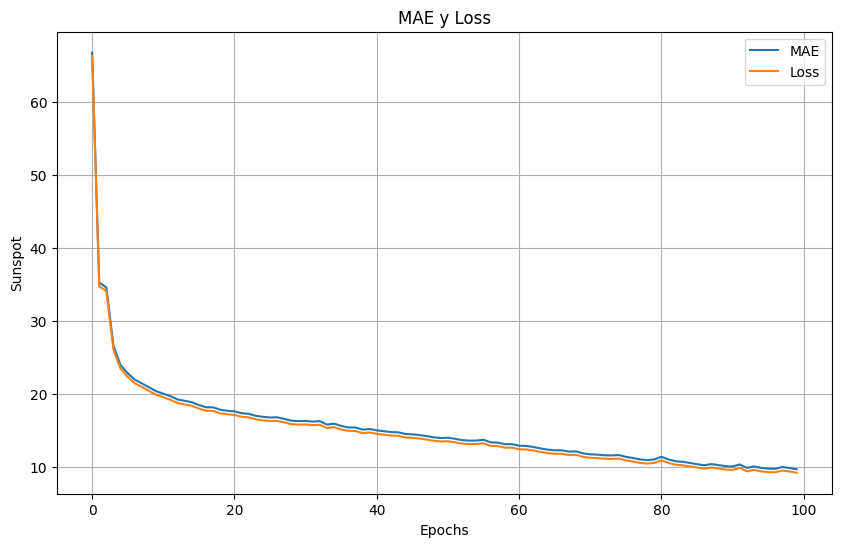

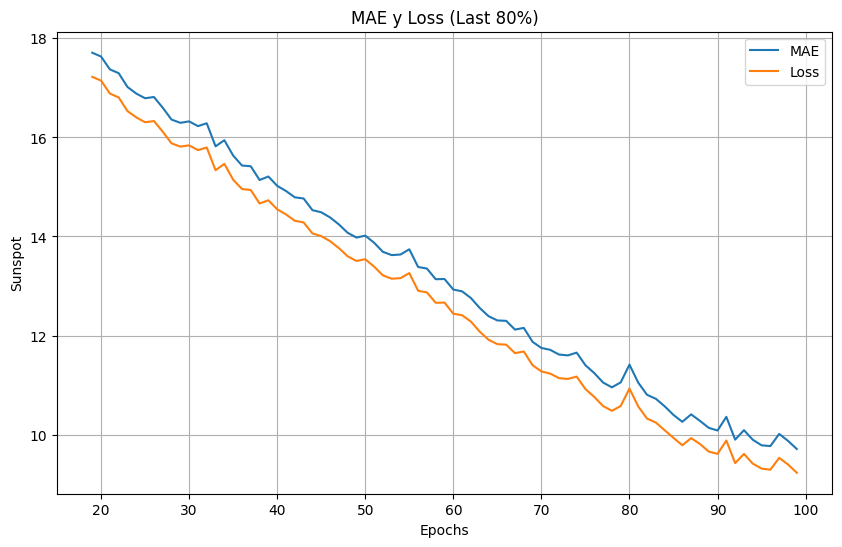

In [219]:
visualize_evaluation(history_RNN)

**LSTM Evaluation**

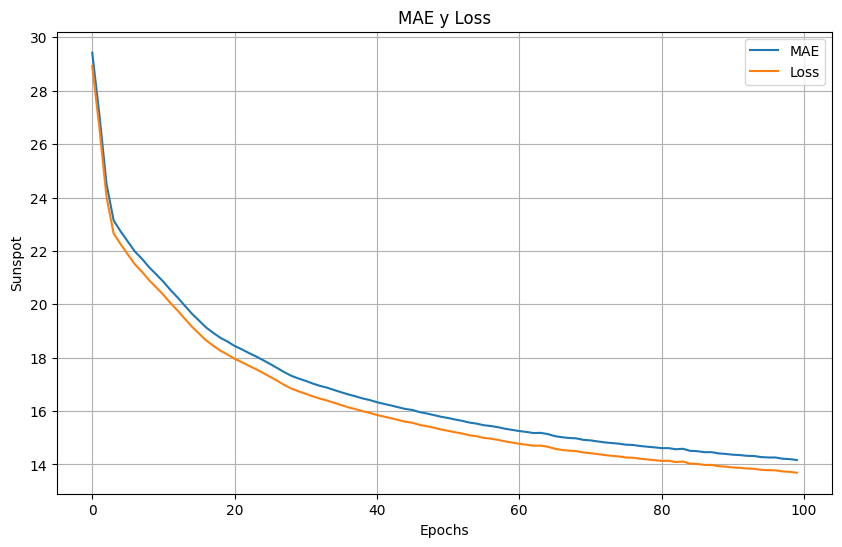

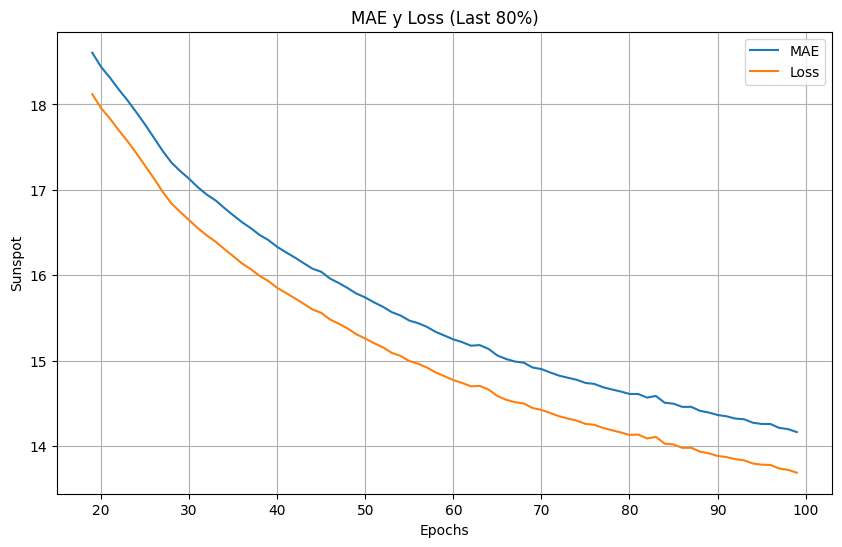

In [220]:
visualize_evaluation(history_LSTM)

**GRU Evaluation**

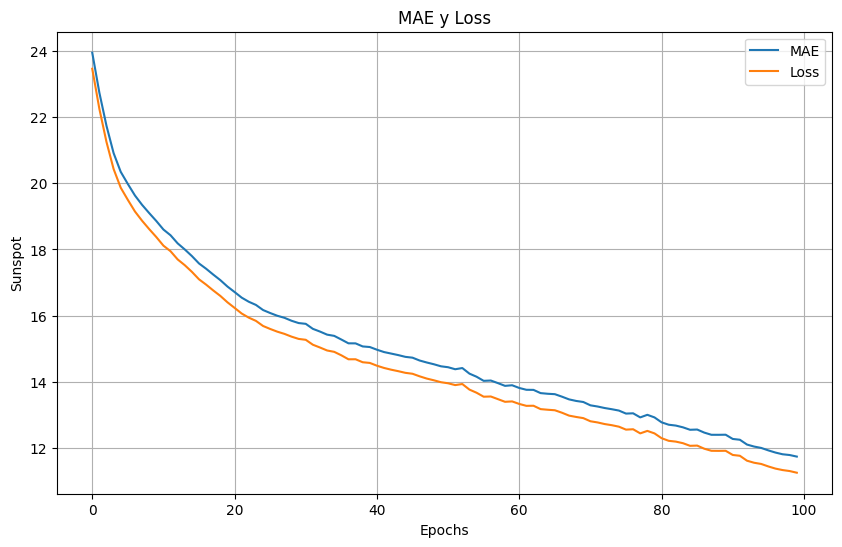

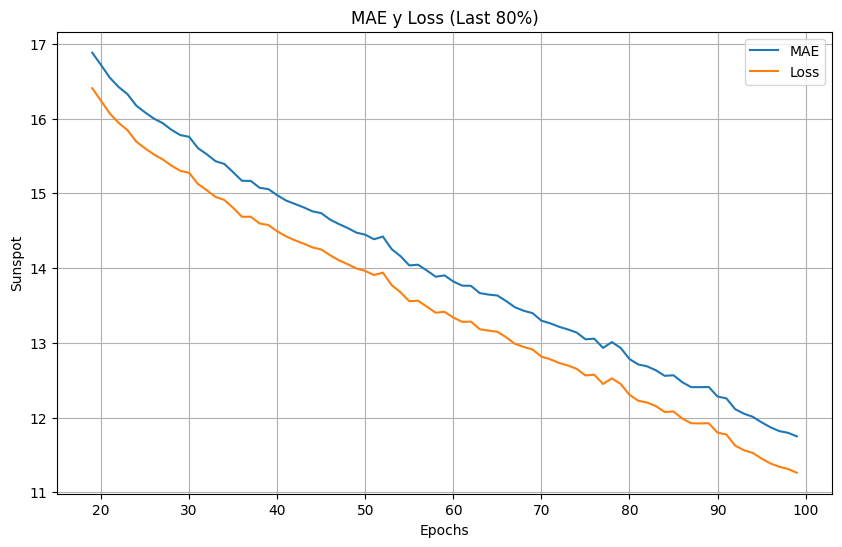

In [221]:
visualize_evaluation(history_GRU)

**RNN-LSTM Evaluation**

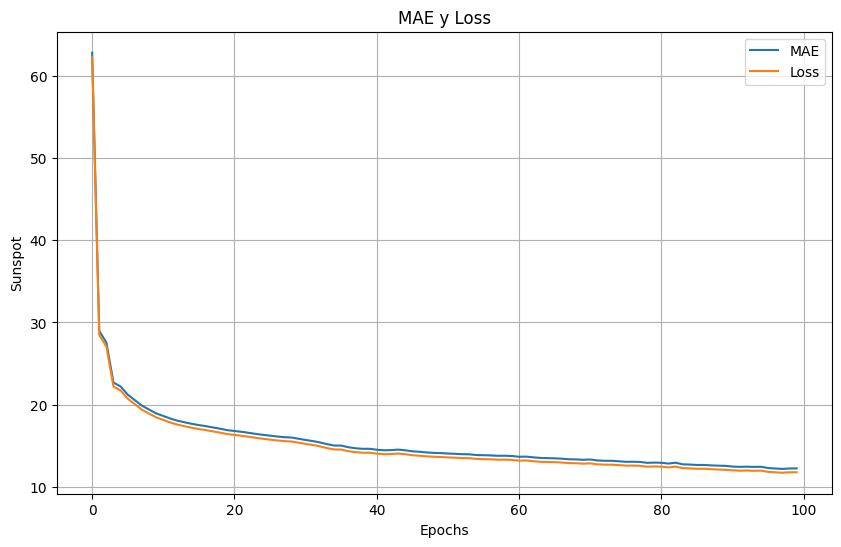

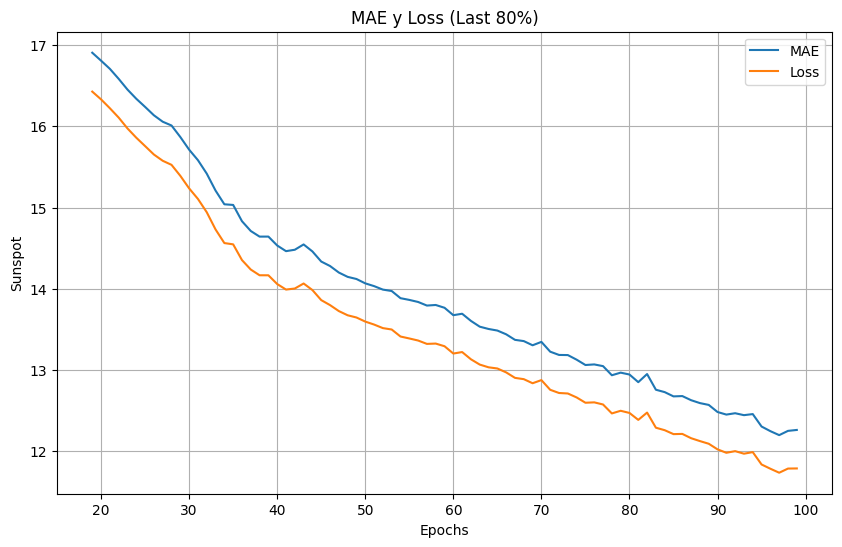

In [222]:
visualize_evaluation(history_RNN_LSTM)

**RNN-GRU Evaluation**

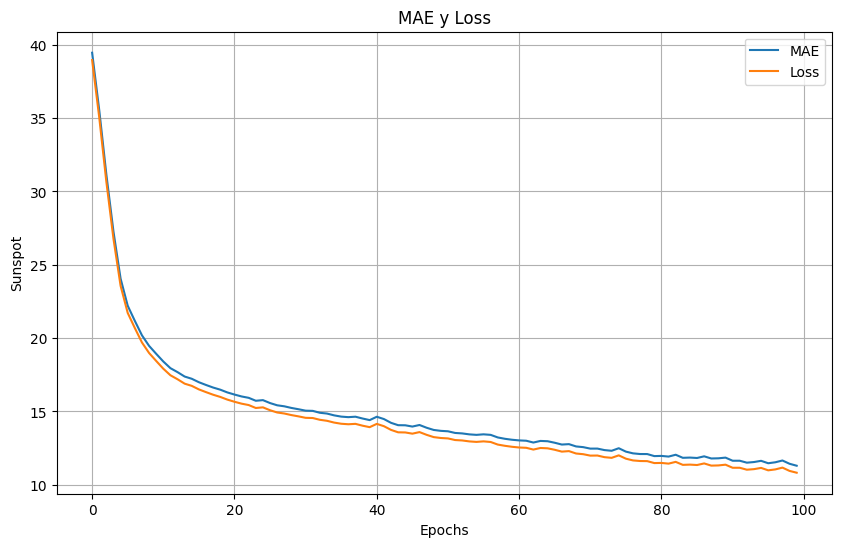

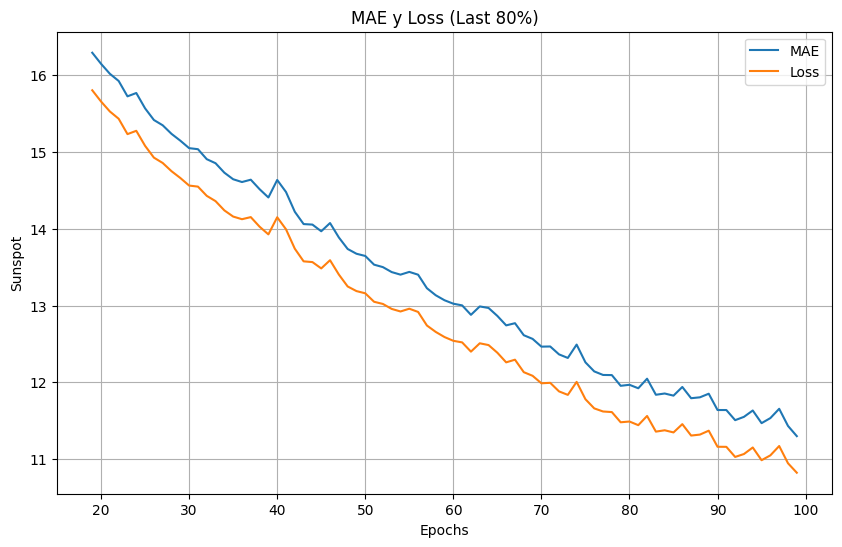

In [223]:
visualize_evaluation(history_RNN_GRU)

**LSTM-RNN Evaluation**

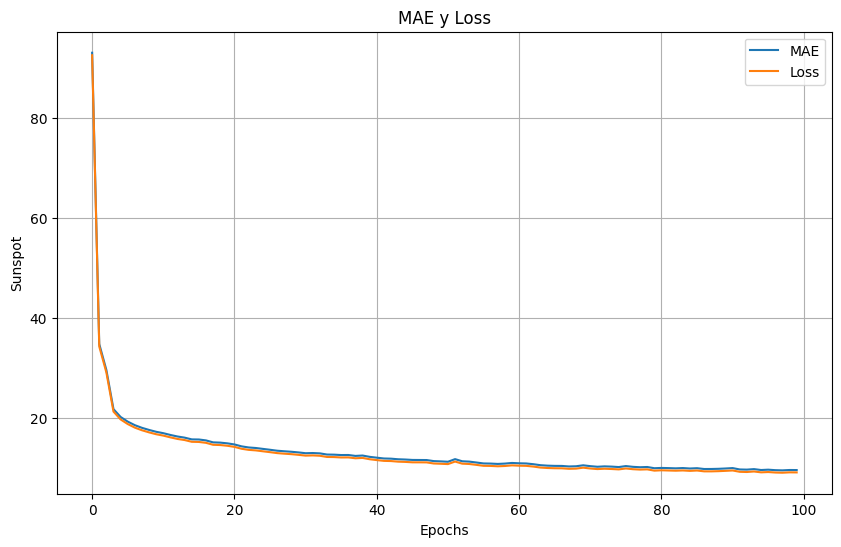

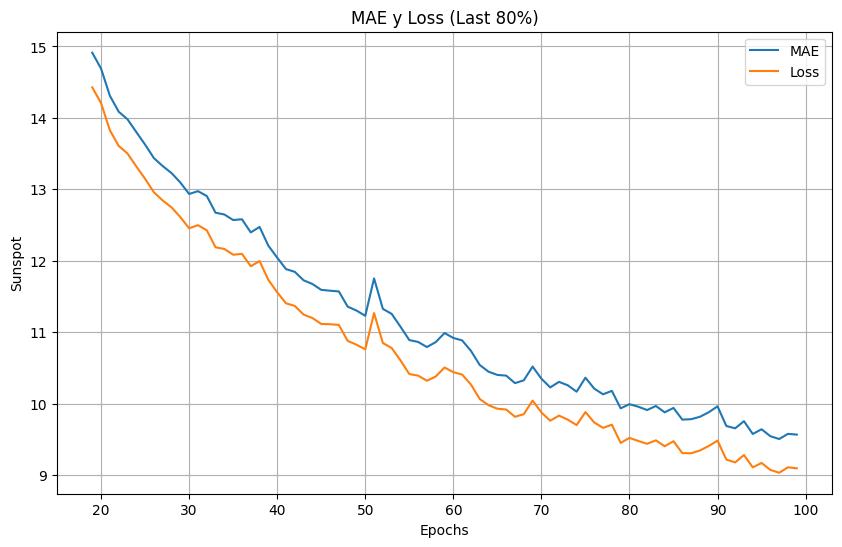

In [224]:
visualize_evaluation(history_LSTM_RNN)

**LSTM-GRU Evaluation**

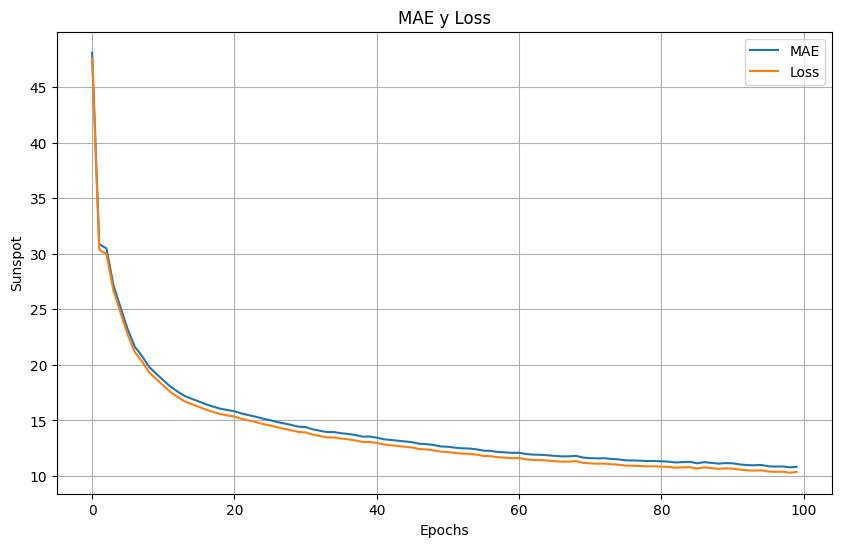

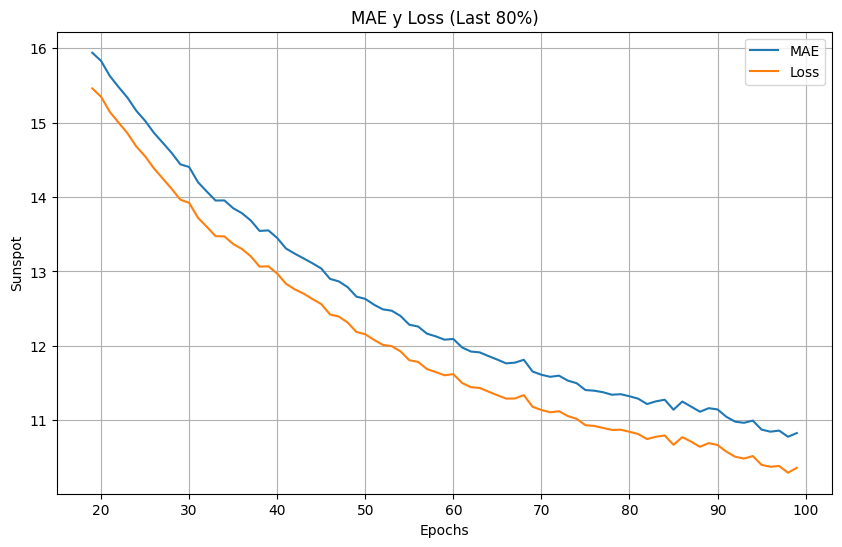

In [225]:
visualize_evaluation(history_LSTM_GRU)

**GRU-RNN Evaluation**

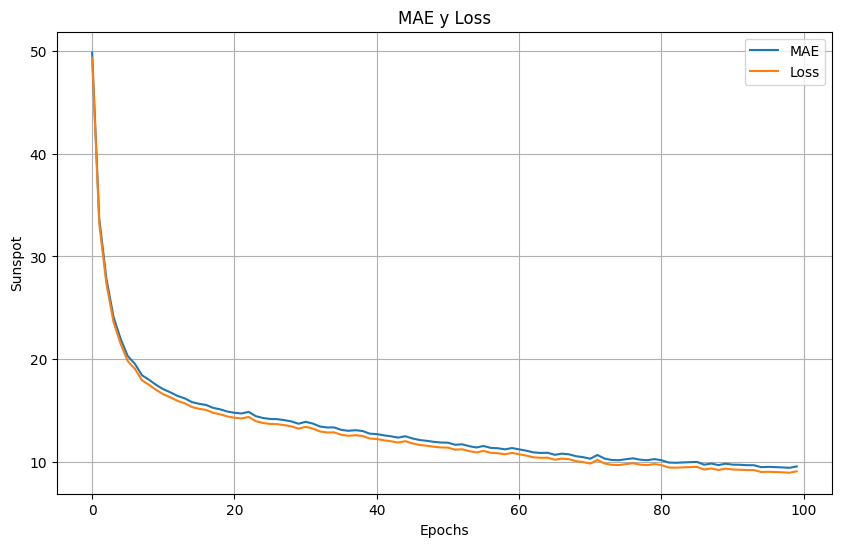

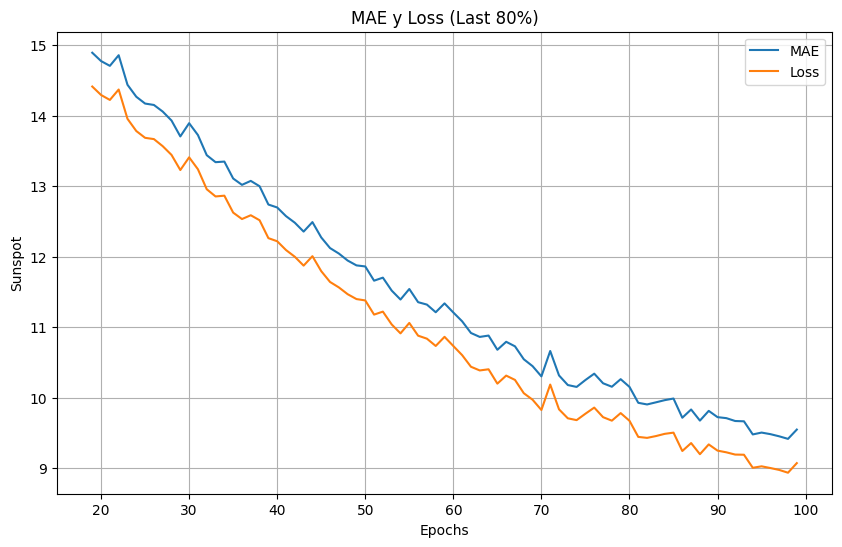

In [226]:
visualize_evaluation(history_GRU_RNN)

**GRU-LSTM Evaluation**

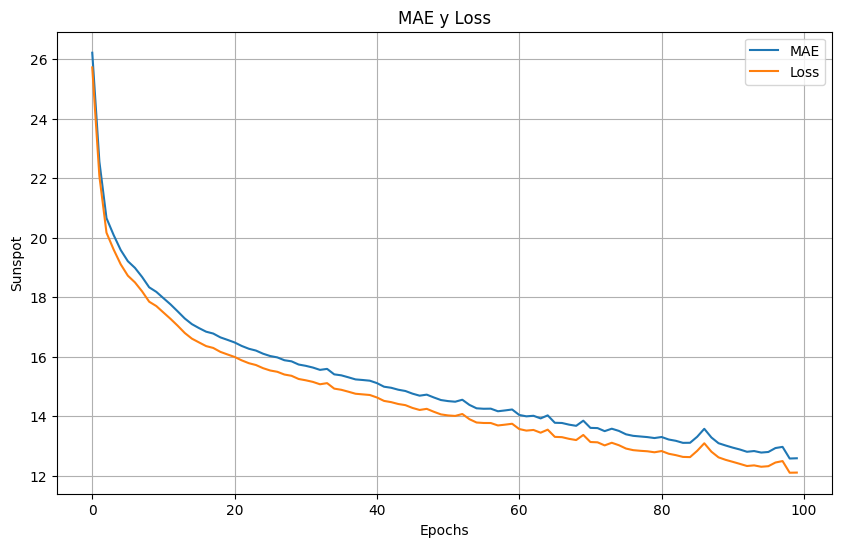

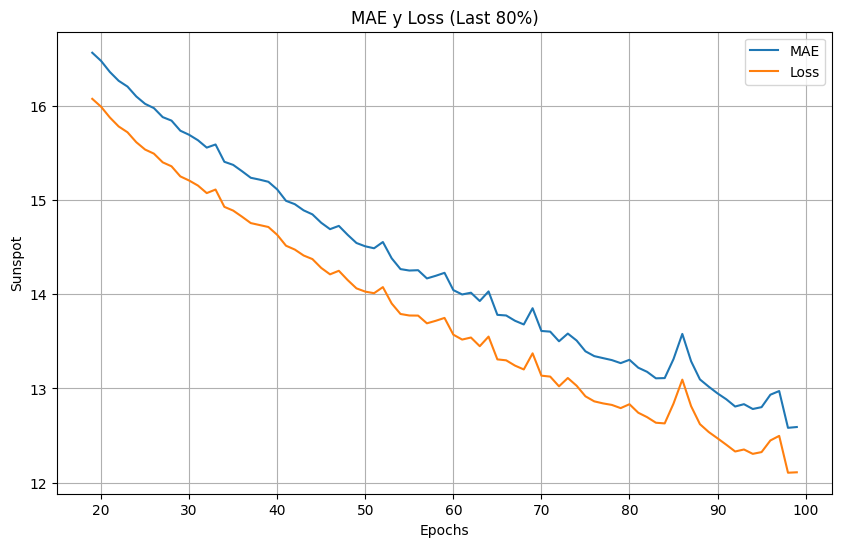

In [227]:
visualize_evaluation(history_GRU_LSTM)

**GRU-LSTM Evaluation**

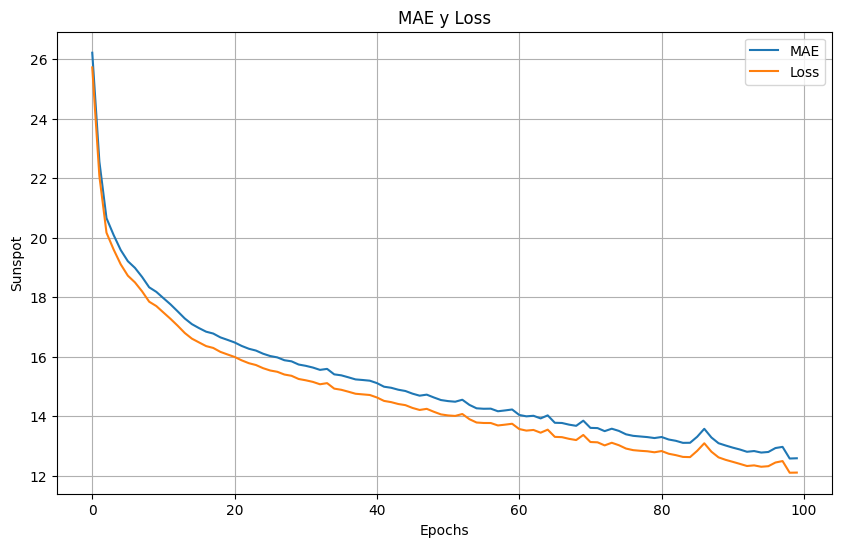

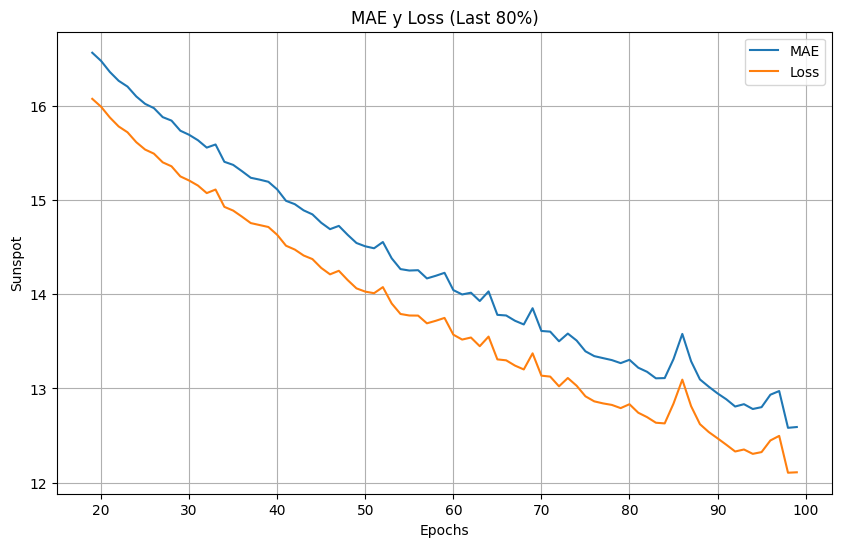

In [228]:
visualize_evaluation(history_GRU_LSTM)

####**7. Model Prediction**

**Analysis outcome of clustering for whale transaction characteristic**

In [229]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset.repeat(1)) # Add .repeat(1) to prevent warning
    return forecast

In [230]:
def predict(model):
    forecast_series = series[split_time-window_size:-1]
    forecast = model_forecast(model, forecast_series, window_size, batch_size)
    results = forecast.squeeze()
    plot_series(time_valid, (x_valid, results, ), title='Resultados pronósticados',
                xlabel='Semanas epidemiológicas',
                ylabel='Casos',
                legend=['Valor pronosticado', 'Valor actual'])

**RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step


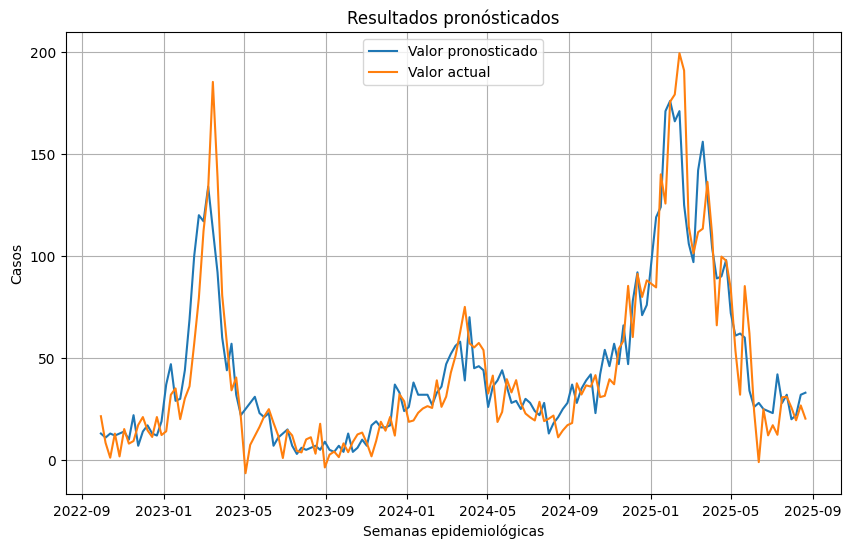

In [231]:
predict(model_RNN)

**LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


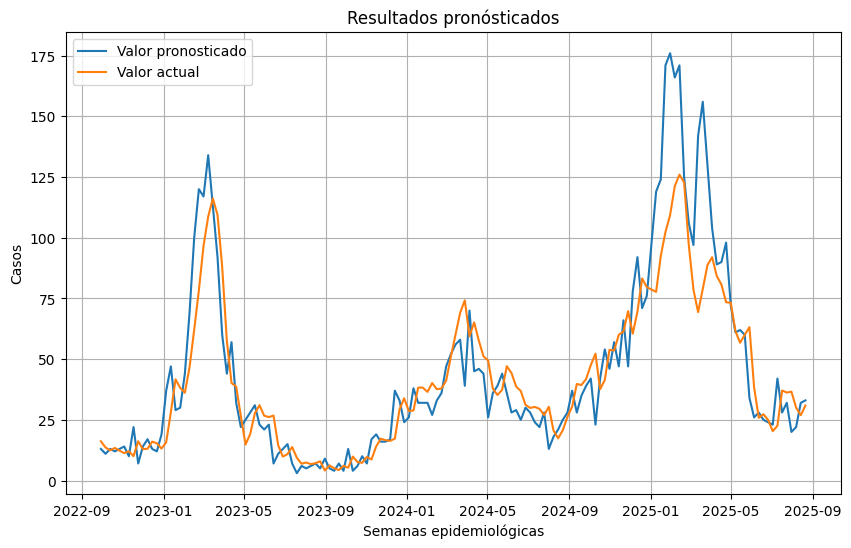

In [232]:
predict(model_LSTM)

**GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step


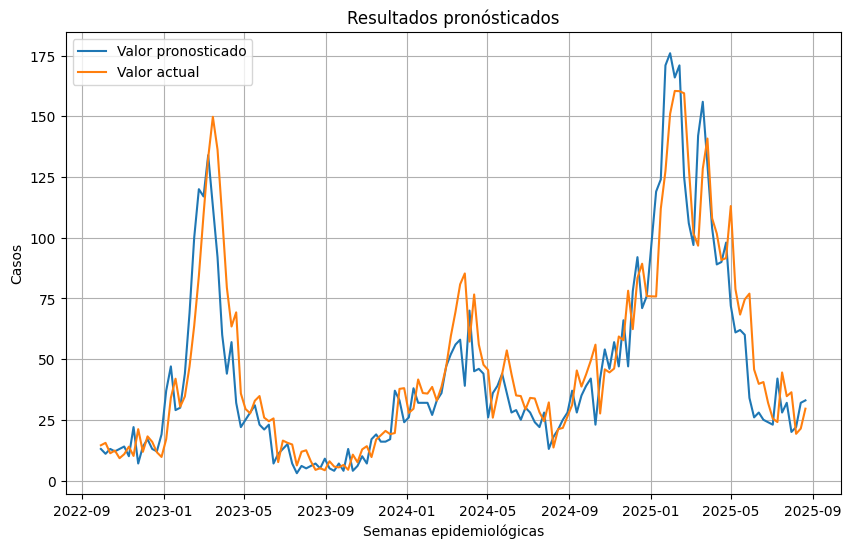

In [233]:
predict(model_GRU)

**RNN-LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


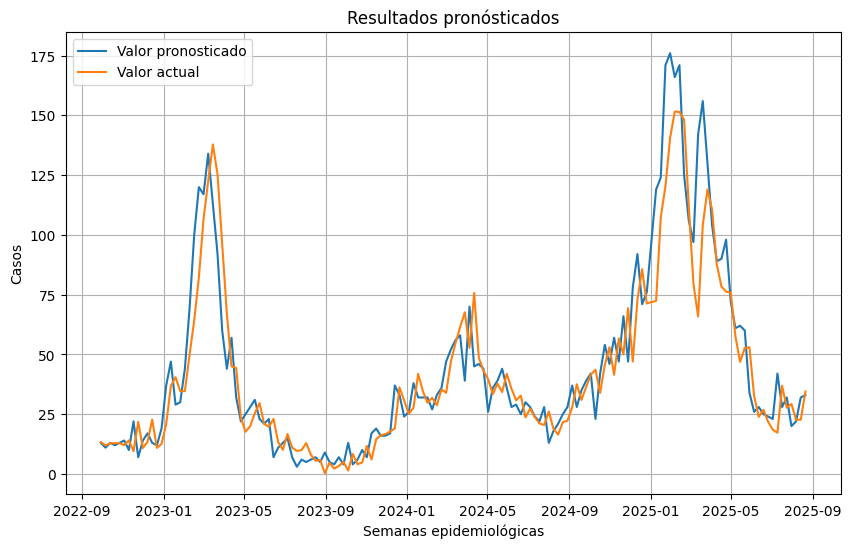

In [234]:
predict(model_RNN_LSTM)

**RNN-GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step


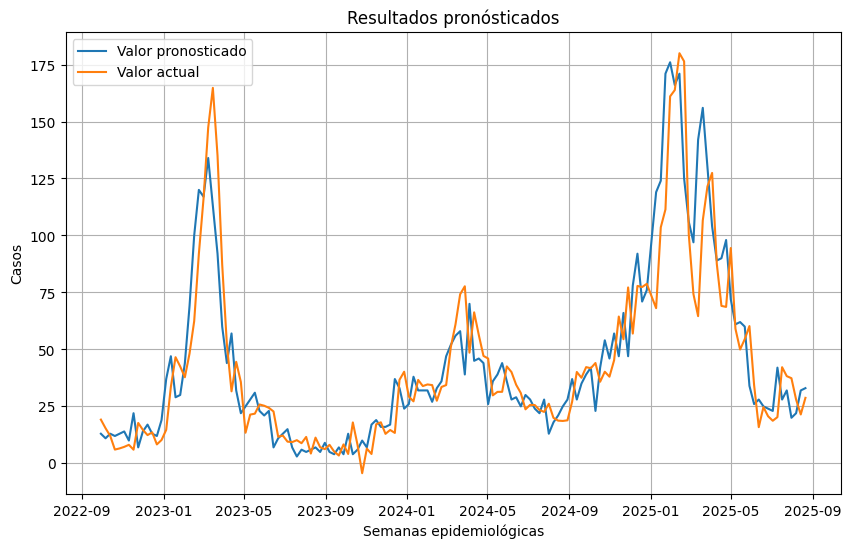

In [235]:
predict(model_RNN_GRU)

**LSTM-RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step


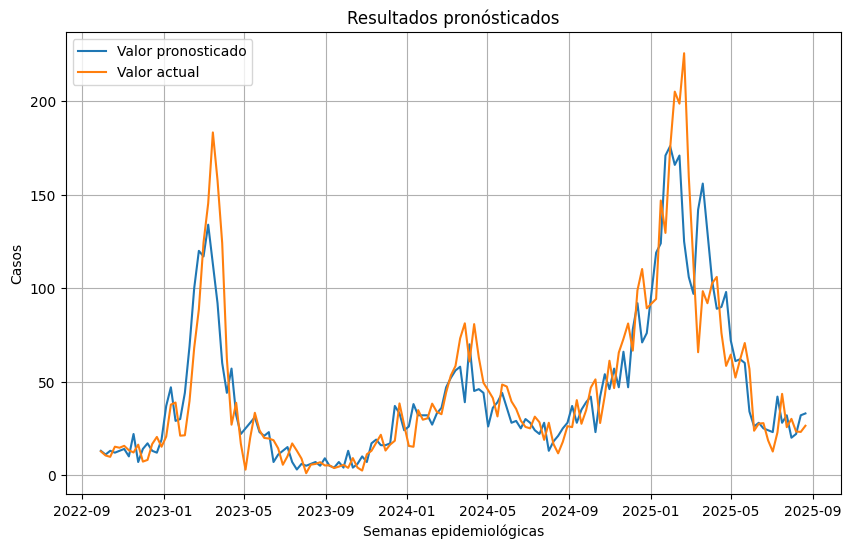

In [236]:
predict(model_LSTM_RNN)

**LSTM-GRU Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step


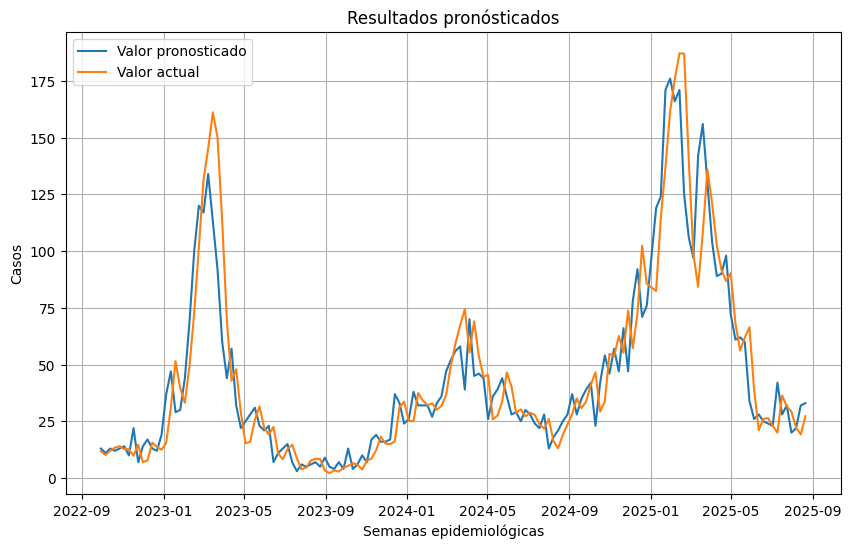

In [237]:
predict(model_LSTM_GRU)

**GRU-RNN Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


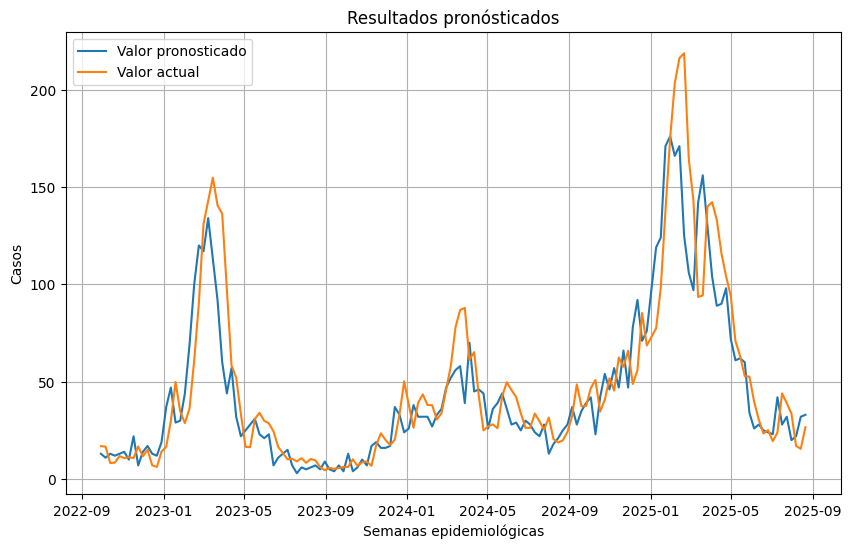

In [238]:
predict(model_GRU_RNN)

**GRU-LSTM Prediction**

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step


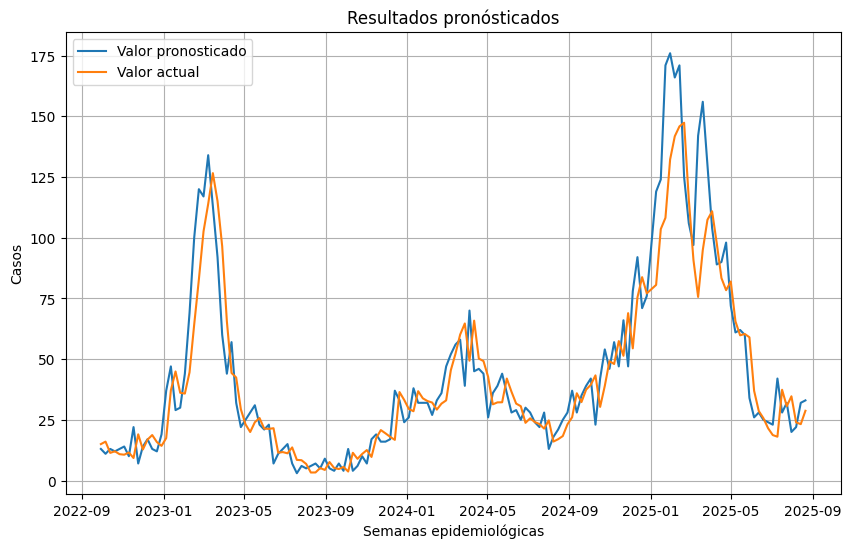

In [239]:
predict(model_GRU_LSTM)

###**Confident Interval**

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


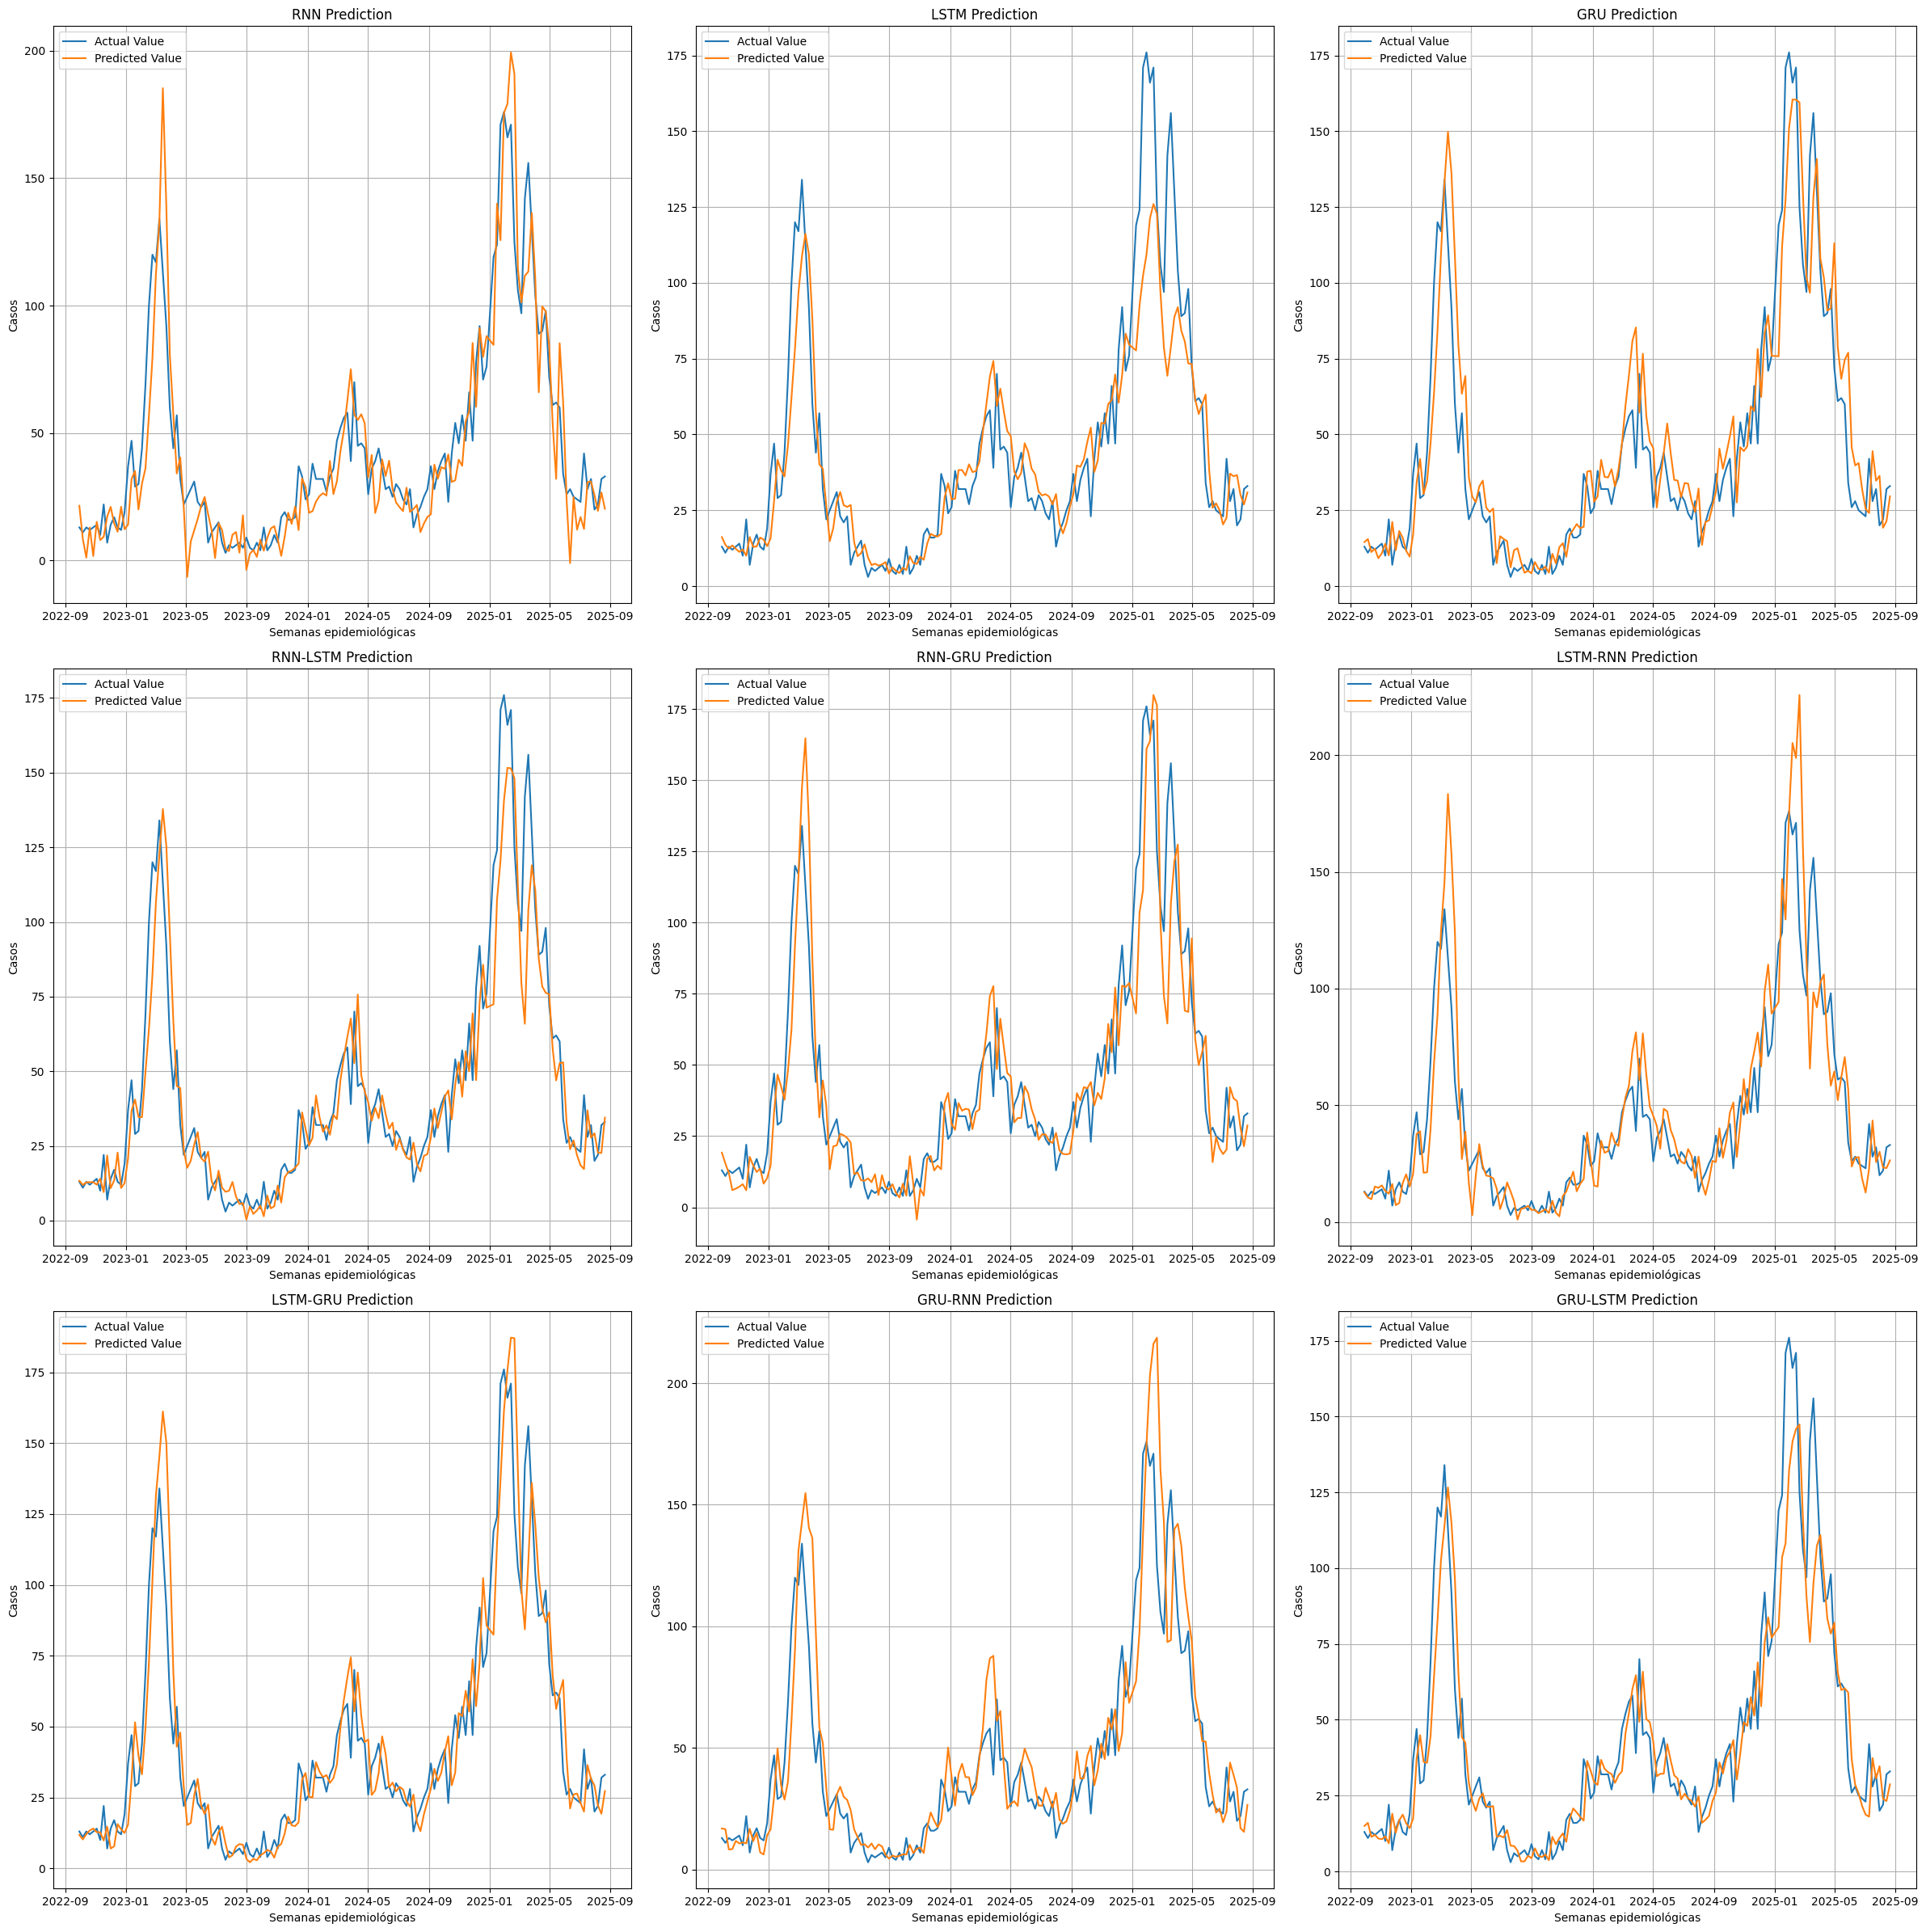

In [240]:
fig, axes = plt.subplots(3, 3, figsize=(24,24))
axes = axes.flatten()

models = {
    'RNN': model_RNN,
    'LSTM': model_LSTM,
    'GRU': model_GRU,
    'RNN-LSTM': model_RNN_LSTM,
    'RNN-GRU': model_RNN_GRU,
    'LSTM-RNN': model_LSTM_RNN,
    'LSTM-GRU': model_LSTM_GRU,
    'GRU-RNN': model_GRU_RNN,
    'GRU-LSTM': model_GRU_LSTM
}

for i, (name, model) in enumerate(models.items()):
    forecast_series = series[split_time - window_size:-1]
    forecast = model_forecast(model, forecast_series, window_size, batch_size)
    results = forecast.squeeze()

    axes[i].plot(time_valid, x_valid, label='Actual Value')
    axes[i].plot(time_valid, results, label='Predicted Value')
    axes[i].set_title(f'{name} Prediction')
    axes[i].set_xlabel('Semanas epidemiológicas')
    axes[i].set_ylabel('Casos')
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=300)
plt.show()

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
import time

**Donwload Data**

In [242]:
!wget https://github.com/kkms51/data/raw/main/GRU_LSTM_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/GRU_RNN_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/GRU_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/LSTM_GRU_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/LSTM_RNN_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/RNN_LSTM_TIME.xlsx
!wget https://github.com/kkms51/data/raw/main/RNN_GRU_TIME.xlsx

--2025-09-28 04:31:23--  https://github.com/kkms51/data/raw/main/GRU_LSTM_TIME.xlsx
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-28 04:31:24 ERROR 404: Not Found.

--2025-09-28 04:31:24--  https://github.com/kkms51/data/raw/main/GRU_RNN_TIME.xlsx
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-28 04:31:24 ERROR 404: Not Found.

--2025-09-28 04:31:24--  https://github.com/kkms51/data/raw/main/GRU_TIME.xlsx
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-28 04:31:24 ERROR 404: Not Found.

--2025-09-28 04:31:24--  https://github.com/kkms51/data/raw/main/LSTM_GRU_TIME.xlsx
Resolving github.co

In [243]:
!wget https://drive.google.com/uc?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8 -O RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=17Z12L9mQh91d7wz5tu2V4ywzrVJ91hRj -O RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1sgrbiaGJrwF-AEXEr8R5x2Ulk95dq56K -O LSTM_PREDICT.xlsx
!wget https://drive.google.com/uc?id=11dDMmQ8RWVDHcZuNyEeWlC-k0nHx5pv4 -O LSTM_LOSS.xlsx
!wget https://drive.google.com/uc?id=1RCRBAGpTxkxruxc-XBDxBUq5A-eIS7RB -O GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1jzDhLE81rWPZffIwBg-MvuMqVPpg-bY- -O GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1ar8H4y9QWquY6zM_cxpk3vp_aDy6gcjU -O RNN_GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1Lmaa9hUtdTD_OFdC4aRwfYxtMjjLWU7i -O RNN_GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1Fg9-g0HfM6OPAIBetFllDdiHOQDU7_Pe -O LSTM_RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1uHwTBW5IhPG9cnnBN3P5vGAW0HlJEUfG -O LSTM_RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1xOn5Jvk_5hzaLVbmCWMSulcEqPzJNm29 -O LSTM_GRU_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1RkZQ50WhKxoCRswyMTEDp-Jpfbwm5six -O LSTM_GRU_LOSS.xlsx
!wget https://drive.google.com/uc?id=1-uCIfgqEUmM2EOiFb9v7iBVRL1kMMXj1 -O GRU_RNN_PREDICT.xlsx
!wget https://drive.google.com/uc?id=18hpQAoeUicSeYaJb0SKuHj-Op6LAHXrG -O GRU_RNN_LOSS.xlsx
!wget https://drive.google.com/uc?id=1gXJIGhIKKkPERaecvST5rX16lrnqGZ1j -O GRU_LSTM_PREDICT.xlsx
!wget https://drive.google.com/uc?id=1MGNVSDpfEerjj9fOlZI3LYkLxN6YHGiS -O GRU_LSTM_LOSS.xlsx

--2025-09-28 04:31:26--  https://drive.google.com/uc?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8
Resolving drive.google.com (drive.google.com)... 74.125.195.102, 74.125.195.138, 74.125.195.101, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8 [following]
--2025-09-28 04:31:26--  https://drive.usercontent.google.com/download?id=1OusiKKuYGBZxP41JqALwjS5fiZ5bVET8
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 74.125.20.132, 2607:f8b0:400e:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|74.125.20.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 232199 (227K) [application/octet-stream]
Saving to: ‘RNN_PREDICT.xlsx’

RNN_PREDICT.xlsx    100%[===================>] 226.76K  --.-KB/s    in 0.002s  

2025-09-28 04:31:27 (120 MB/s) -

**Viz**

In [244]:
import matplotlib.pyplot as plt

from re import X
def shade_plot(temp, x_valid='0', line='MAE', predict=''):
    import matplotlib.pyplot as plt
    if predict == '':
        redline = f'Mean {line}'
        axis = 'Epochs'
    else:
        redline = 'Valor actual'
        axis = 'Semanas epidemilógicas'
    #SORT
    temp = temp.apply(lambda x: x.sort_values().reset_index(drop=True))
    #CUT 2.5%
    n = int(len(temp) * 0.025)
    temp = temp.iloc[n:-n]
    batas_atas = temp.max().tolist()
    batas_bawah = temp.min().tolist()
    rata = temp.mean().tolist()
    # Replace these lists with your actual data
    # Dataset 1
    x1 = [i for i in range(0,len(batas_atas))]

    y1 = batas_atas
    # Dataset 2
    x2 = [i for i in range(0,len(batas_bawah))]
    y2 = batas_bawah
    if(x_valid=='0'):
        # Dataset 3
        x3 = [i for i in range(0,len(rata))]
        y3 = rata
    else:
        x3 = [i for i in range(0,len(x_valid))]
        y3 = x_valid
    # Create the plot
    plt.figure(figsize=(8, 6))
    # Plot the first linear dataset
    plt.plot(x1, y1, label=f'Valor pronóstico (Max)', color='blue')
    # Plot the second linear dataset
    plt.plot(x2, y2, label=f'Valor pronóstico (Min)', color='green')
    plt.plot(x3, y3, label=f'{redline}', color='red')
    # Create a mask for the shaded area where y1 >= y2
    mask = [y1_val >= y2_val for y1_val, y2_val in zip(y1, y2)]
    # Shade the area between the two datasets
    plt.fill_between(x1, y1, y2, where=mask, interpolate=True, color='gray', alpha=0.5)
    # Add labels and legend
    plt.xlabel(f'{axis}')
    plt.ylabel('Casos')
    plt.title(f'Comparación de valores reales y previstos utilizando {line} durante 100 iteraciones - Datos')
    plt.legend()
    plt.savefig(f"Predicted_Actual_Value_Dataset2_{line}.pdf", dpi=300)
    files.download(f"Predicted_Actual_Value_Dataset2_{line}.pdf")
    # Show the plot
    plt.grid(True)
    plt.show()

In [245]:
!wget https://raw.githubusercontent.com/MhdIqbalPratama/ware-house/main/Data%20COVID-19%20Indon

--2025-09-28 04:31:50--  https://raw.githubusercontent.com/MhdIqbalPratama/ware-house/main/Data%20COVID-19%20Indon
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-09-28 04:31:50 ERROR 404: Not Found.



**RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

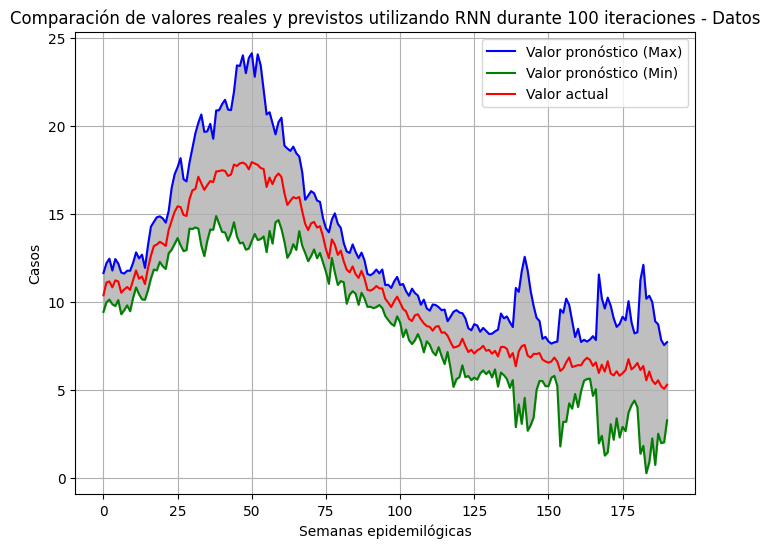

In [246]:
temp = pd.read_excel('RNN_PREDICT.xlsx')
shade_plot(temp, line='RNN', predict='YES')

**LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

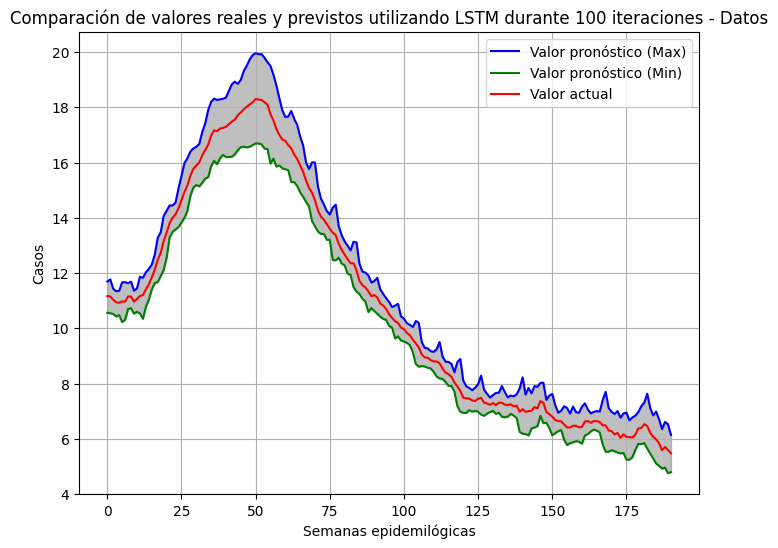

In [247]:
temp = pd.read_excel('LSTM_PREDICT.xlsx')
shade_plot(temp, line='LSTM', predict='YES')

**GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

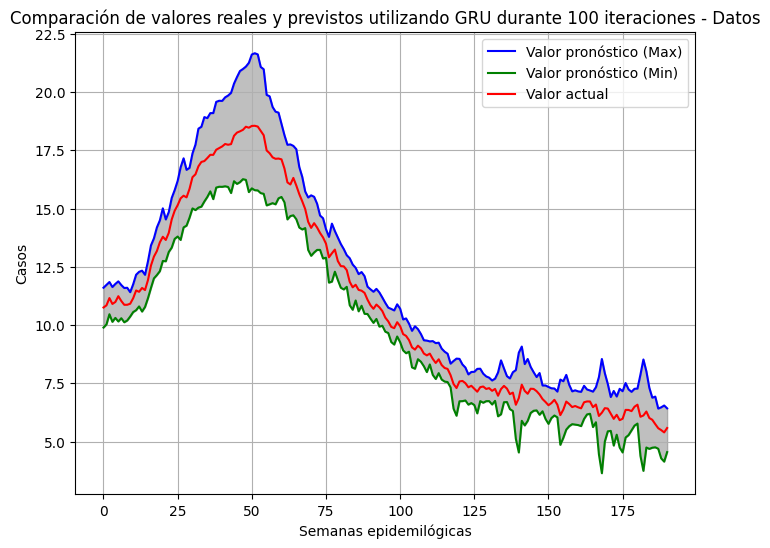

In [248]:
temp = pd.read_excel('GRU_PREDICT.xlsx')
shade_plot(temp, line='GRU', predict='YES')

In [249]:
!gdown 1Jcj7_vtMQ2foct0YPmWC6nO9q4T_x3bl
!gdown 1d-M7kCjRcggRBII-8o9WUhbWPaFxcPRg

Downloading...
From: https://drive.google.com/uc?id=1Jcj7_vtMQ2foct0YPmWC6nO9q4T_x3bl
To: /content/RNN_LSTM_PREDICT.xlsx
100% 230k/230k [00:00<00:00, 97.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1d-M7kCjRcggRBII-8o9WUhbWPaFxcPRg
To: /content/RNN_LSTM_LOSS.xlsx
100% 127k/127k [00:00<00:00, 75.0MB/s]


**RNN-LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

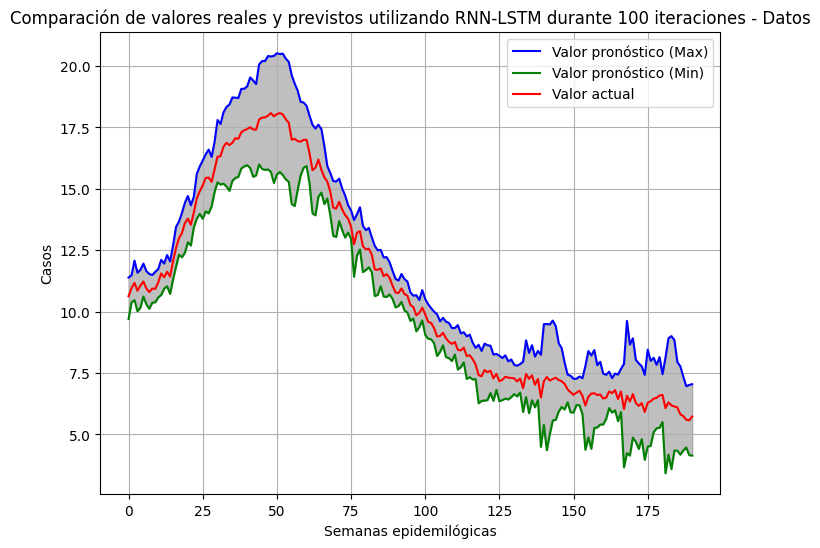

In [250]:
temp = pd.read_excel('RNN_LSTM_PREDICT.xlsx')
shade_plot(temp, line='RNN-LSTM', predict='YES')

**RNN-GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

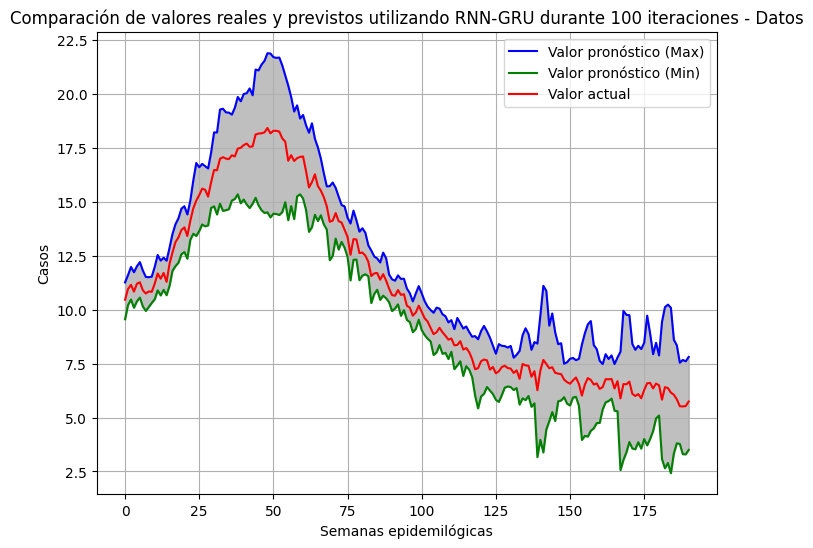

In [251]:
temp = pd.read_excel('RNN_GRU_PREDICT.xlsx')
shade_plot(temp, line='RNN-GRU', predict='YES')

**LSTM-RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

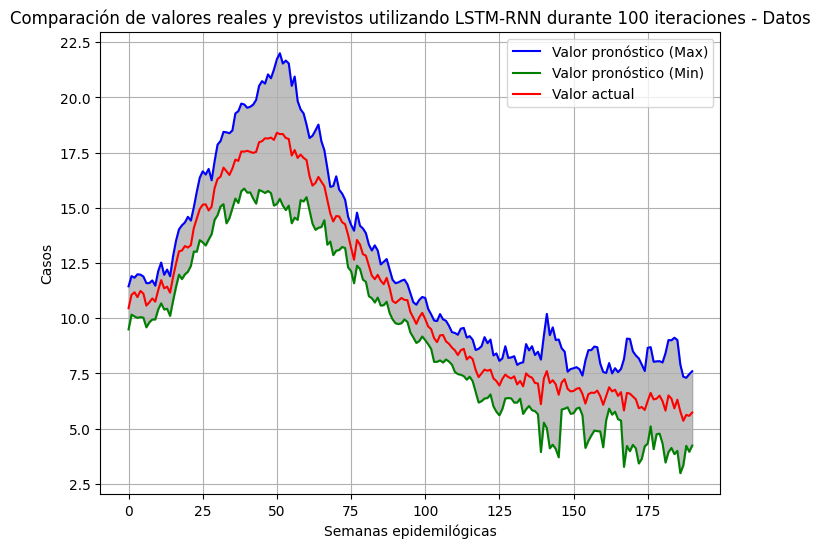

In [252]:
temp = pd.read_excel('LSTM_RNN_PREDICT.xlsx')
shade_plot(temp, line='LSTM-RNN', predict='YES')

**LSTM-GRU**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

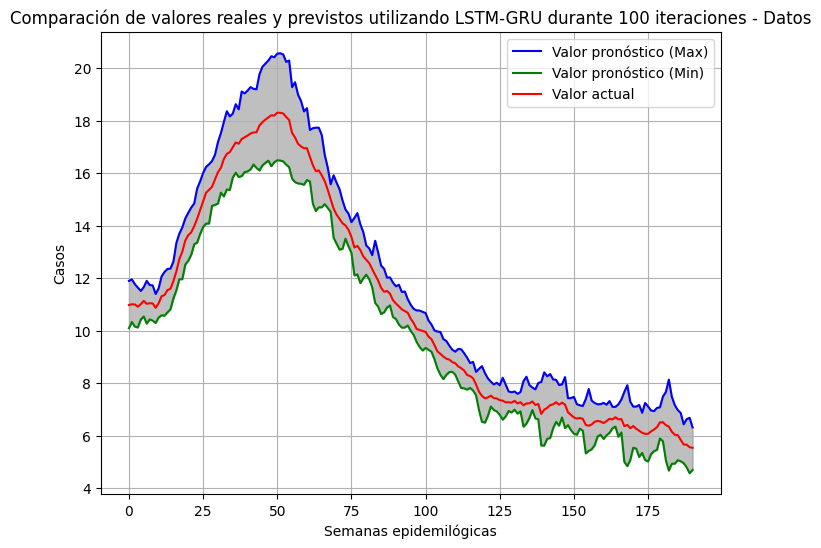

In [253]:
temp = pd.read_excel('LSTM_GRU_PREDICT.xlsx')
shade_plot(temp, line='LSTM-GRU', predict='YES')

**GRU-RNN**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

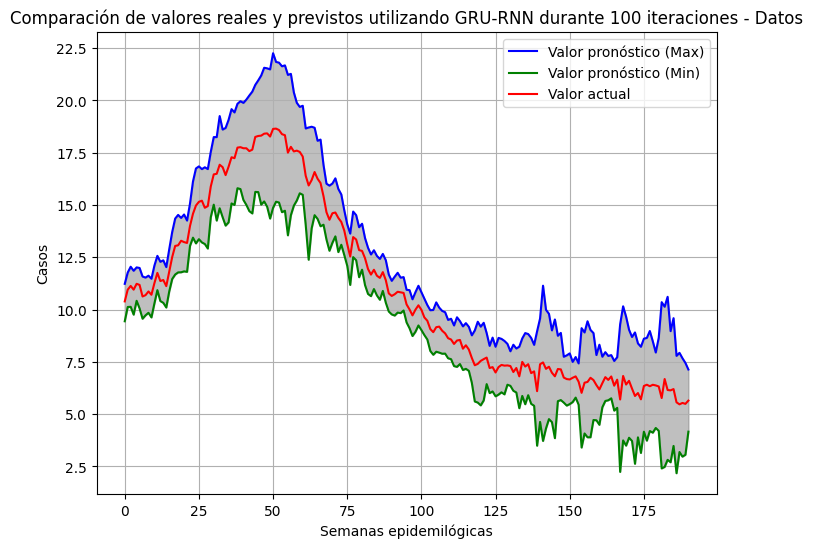

In [254]:
temp = pd.read_excel('GRU_RNN_PREDICT.xlsx')
shade_plot(temp, line='GRU-RNN', predict='YES')

**GRU-LSTM**

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

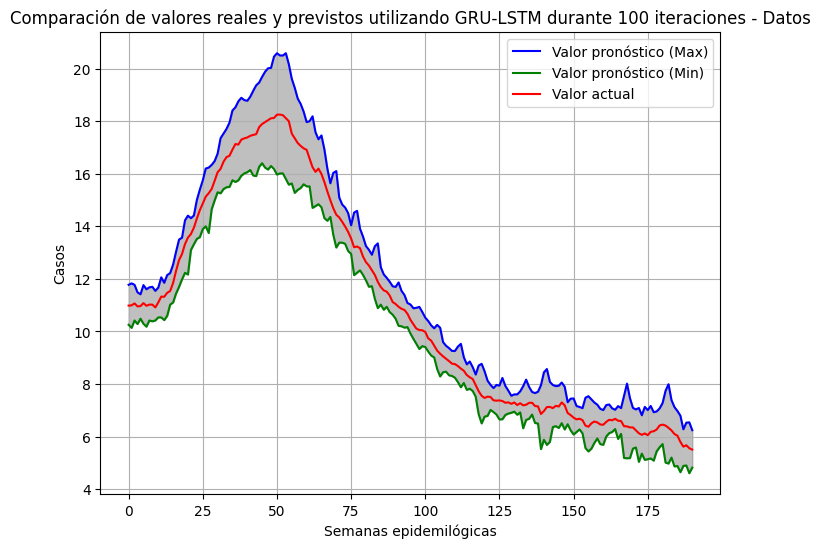

In [255]:
temp = pd.read_excel('GRU_LSTM_PREDICT.xlsx')
shade_plot(temp, line='GRU-LSTM', predict='YES')

In [256]:
import matplotlib.pyplot as plt

from re import X
def shade_plot(temp, x_valid='0', line='MAE', predict='', ax=None):
    if predict == '':
        redline = f'Mean {line}'
        axis = 'Epochs'
    else:
        redline = 'Valor actual'
        axis = 'Semanas epidemiológicas'
    #SORT
    temp = temp.apply(lambda x: x.sort_values().reset_index(drop=True))
    #CUT 2.5%
    n = int(len(temp) * 0.025)
    temp = temp.iloc[n:-n]
    batas_atas = temp.max().tolist()
    batas_bawah = temp.min().tolist()
    rata = temp.mean().tolist()
    # Replace these lists with your actual data
    # Dataset 1
    x1 = [i for i in range(0,len(batas_atas))]

    y1 = batas_atas
    # Dataset 2
    x2 = [i for i in range(0,len(batas_bawah))]
    y2 = batas_bawah
    if(x_valid=='0'):
        # Dataset 3
        x3 = [i for i in range(0,len(rata))]
        y3 = rata
    else:
        x3 = [i for i in range(0,len(x_valid))]
        y3 = x_valid

    if ax is None:
        # Create the plot
        plt.figure(figsize=(8, 6))
        ax = plt.gca()

    # Plot the first linear dataset
    ax.plot(x1, y1, label=f'Predicted Value (Max)', color='blue')
    # Plot the second linear dataset
    ax.plot(x2, y2, label=f'Predicted Value (Min)', color='green')
    ax.plot(x3, y3, label=f'{redline}', color='red')
    # Create a mask for the shaded area where y1 >= y2
    mask = [y1_val >= y2_val for y1_val, y2_val in zip(y1, y2)]
    # Shade the area between the two datasets
    ax.fill_between(x1, y1, y2, where=mask, interpolate=True, color='gray', alpha=0.5)
    # Add labels and legend
    ax.set_xlabel(f'{axis}')
    ax.set_ylabel('Casos')
    ax.set_title(f'Valores reales y pronosticadosos utilizando {line} durante 100 iteraciones - Datos')

    ax.legend()
    # plt.savefig(f"Predicted_Actual_Value_Dataset2_{line}.pdf", dpi=300)
    # files.download(f"Predicted_Actual_Value_Dataset2_{line}.pdf")
    # Show the plot
    ax.grid(True)

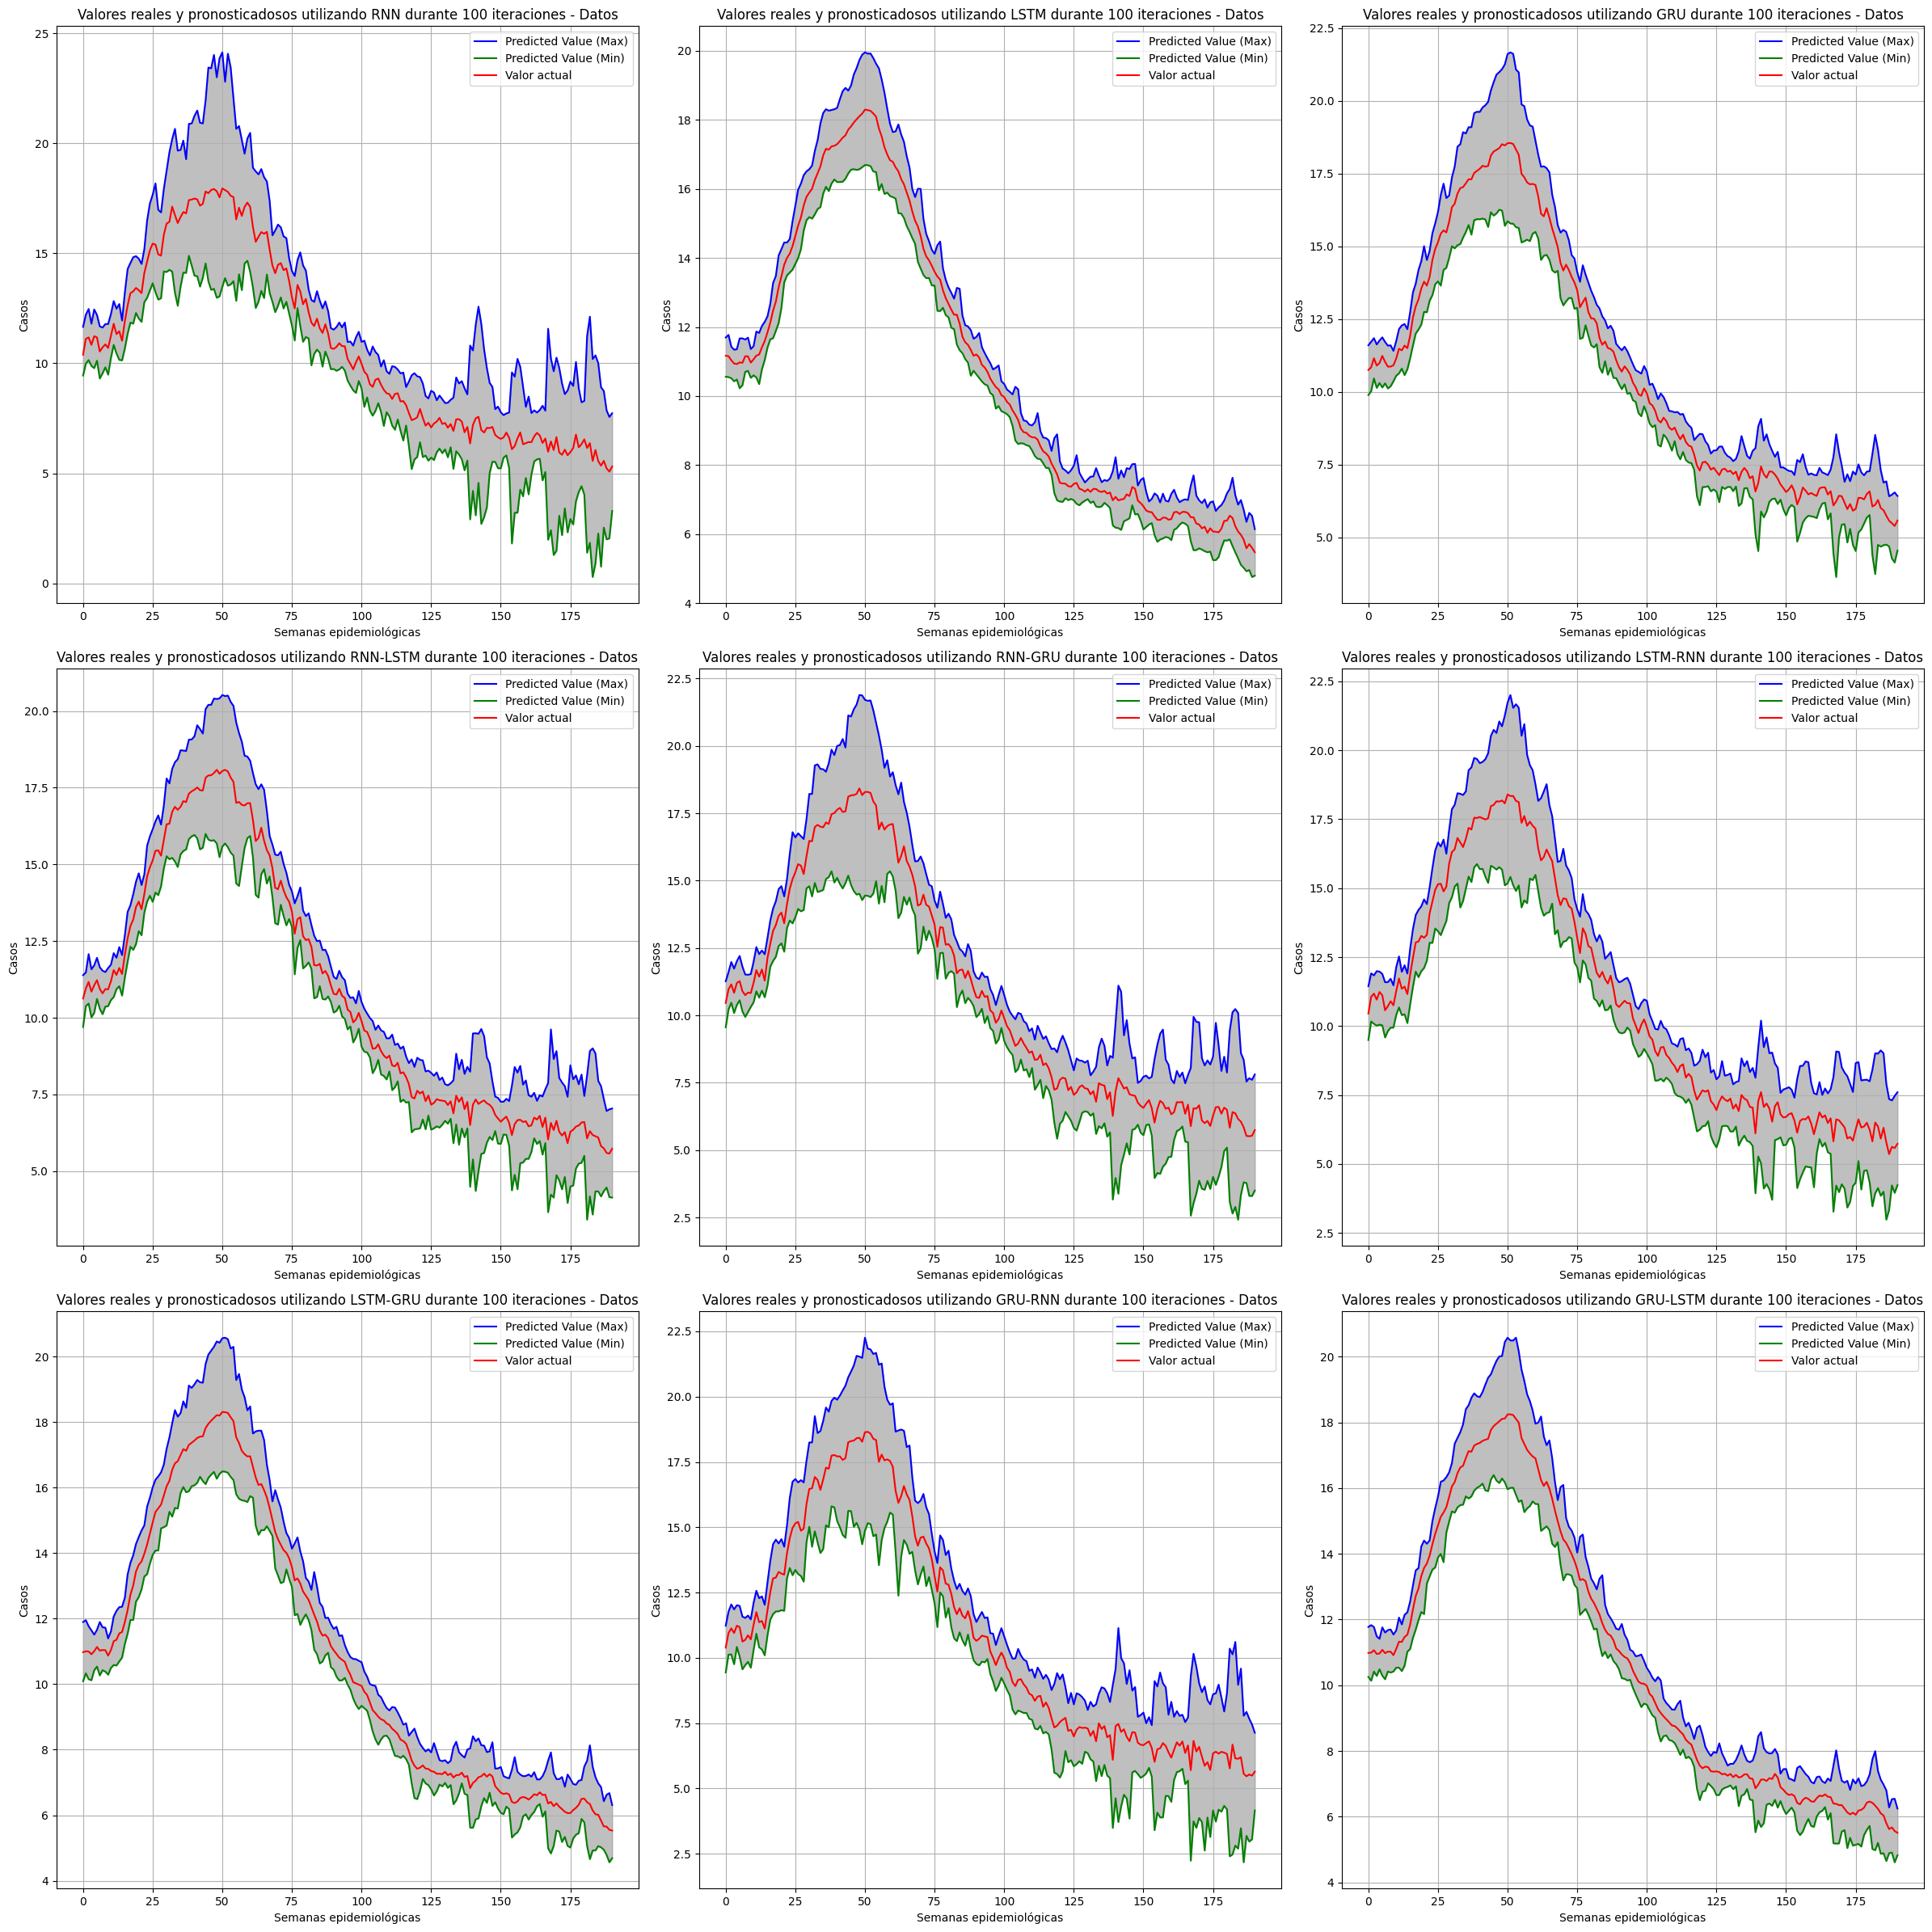

In [257]:
fig, axes = plt.subplots(3, 3, figsize=(24, 24))
axes = axes.flatten()

models_predict = {
    'RNN': 'RNN_PREDICT.xlsx',
    'LSTM': 'LSTM_PREDICT.xlsx',
    'GRU': 'GRU_PREDICT.xlsx',
    'RNN-LSTM': 'RNN_LSTM_PREDICT.xlsx',
    'RNN-GRU': 'RNN_GRU_PREDICT.xlsx',
    'LSTM-RNN': 'LSTM_RNN_PREDICT.xlsx',
    'LSTM-GRU': 'LSTM_GRU_PREDICT.xlsx',
    'GRU-RNN': 'GRU_RNN_PREDICT.xlsx',
    'GRU-LSTM': 'GRU_LSTM_PREDICT.xlsx'
}

for i, (name, file_name) in enumerate(models_predict.items()):
    temp = pd.read_excel(file_name)
    shade_plot(temp, line=name, predict='YES', ax=axes[i])

plt.tight_layout()
plt.savefig('combined_shade_plots.png', dpi=300)
plt.show()

**DONWLOAD DATA**

In [258]:
!gdown 1_Xk_aBt72cg0IhtrDHByatBuGuLi-svr
!gdown 1ZrtG6EfZxXeV19WMzla_qniBb4E0vHGp
!gdown 1YCs0hRgt-wpSVI7EbtLit5HvjM7brmtB
!gdown 194--ZfpP3lr5eg8jfjbDLSWDSvWVVx18
!gdown 1mrYem8IETC1Bvv4XLfkuFc_Yxs0L-1M5
!gdown 11ElHC2LM013wujQwqW12SD6gDrv60mOl
!gdown 1f62wFr9ML2AAO39aeU2dbKsmh3idLyOi
!gdown 1EImqlbcinVzjSxp5wM27YfCo9Nf_YBn0

Downloading...
From: https://drive.google.com/uc?id=1_Xk_aBt72cg0IhtrDHByatBuGuLi-svr
To: /content/RNN_TIME.xlsx
100% 10.3k/10.3k [00:00<00:00, 31.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZrtG6EfZxXeV19WMzla_qniBb4E0vHGp
To: /content/RNN_FORECASTRMse.xlsx
100% 6.52k/6.52k [00:00<00:00, 22.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YCs0hRgt-wpSVI7EbtLit5HvjM7brmtB
To: /content/RNN_FORECASTMpe.xlsx
100% 6.50k/6.50k [00:00<00:00, 22.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=194--ZfpP3lr5eg8jfjbDLSWDSvWVVx18
To: /content/RNN_FORECASTMae.xlsx
100% 6.48k/6.48k [00:00<00:00, 21.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1mrYem8IETC1Bvv4XLfkuFc_Yxs0L-1M5
To: /content/LSTM_TIME.xlsx
100% 10.3k/10.3k [00:00<00:00, 32.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=11ElHC2LM013wujQwqW12SD6gDrv60mOl
To: /content/LSTM_FORECASTRMse.xlsx
100% 6.49k/6.49k [00:00<00:00, 23.2MB/s]
Downloading...
From: https://drive.google.co

In [259]:
!gdown 1NyWC6xVK2tlvtjcx0xv8I4O_bI0KebdS
!gdown 1UFgEoC6-313M_dpjq7mW9LICaUvbkoNa
!gdown 1vuERyAz3ckNgg_vAAcjznPa7jpNJN9Rt
!gdown 1ZumVvaJpYdkWhSKZNlqbrHzi--A3iwtx
!gdown 1z0qcyj5D7XoZ4bTMDZ3yaOuHaFaqmXSZ
!gdown 16dF5YhHT4R_g5HbdAsO_cEXejJQ87Pg2
!gdown 1DLTaT7OQxd_R71nSjjj7r7NSJfkG0X8X
!gdown 1A1ARznJ4X2xQM5AL05yfhZo6KIQ21rxZ
!gdown 1fvzFbPqCzqdoLujlHxqIqNlnuCRPddTV
!gdown 1avI3Q59EZV92abBlLrSjNYG05ndLcOJ9
!gdown 16ZR-PaPNwqSyzFj-0SS8AqB7xIJ4OrYe
!gdown 1SgjgWPVq-QTgva1OFAZNKrVzQr0aJwRr
!gdown 1b1zT-srRQd1PEmXi2MyhojUFTGhPTHBM
!gdown 1zsmjBebdjFhh-tm8V4zPF9rQDKs76Vyv
!gdown 1raNErRqrAcr5qFCXH2T1G4bqhbu6l-m5
!gdown 1MHL7n1sIjWsouMWbYfgvDLud-Ba6wWM1
!gdown 1FblK2jeAC9kkZsRp9I6o-64Uqtpql-XI
!gdown 1n718TN1i5kwMEIm0Q6NTcz94D34YXgpA
!gdown 1oy-KECRHSE07R7-78D1tBdiJNbEoxI8E
!gdown 19--phk8Mf1z4QX464ZV_wVL4hfyQmSW1
!gdown 1-JzfQA2dQJe-mXrEK7fdNY1HluF_wSHQ
!gdown 16NiUOKZgspf09ztmREbffpmBKV9zBRhX
!gdown 1mb0yBP7A5seQN2naL8Sgqy54pZ5lYZAZ
!gdown 1CUxws0PZc8T_LWIKyifATBfOzFGMXBi9
!gdown 1ajESJp2rNjlmdWa31-2iIvE8lyvkGKgS
!gdown 14M9gs549r7PLS2CAjEbLoQOiaRfey6X8
!gdown 1j7YuYNeVF4Jt3F3tqG1oH4qgpGwF99jC
!gdown 1Z61vMm0J5Vjn2sNQq87FgaLbAAt8P4or

Downloading...
From: https://drive.google.com/uc?id=1NyWC6xVK2tlvtjcx0xv8I4O_bI0KebdS
To: /content/GRU_TIME.xlsx
100% 10.3k/10.3k [00:00<00:00, 23.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1UFgEoC6-313M_dpjq7mW9LICaUvbkoNa
To: /content/GRU_FORECASTRMse.xlsx
100% 6.50k/6.50k [00:00<00:00, 22.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vuERyAz3ckNgg_vAAcjznPa7jpNJN9Rt
To: /content/GRU_FORECASTMpe.xlsx
100% 6.54k/6.54k [00:00<00:00, 19.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ZumVvaJpYdkWhSKZNlqbrHzi--A3iwtx
To: /content/GRU_FORECASTMae.xlsx
100% 6.52k/6.52k [00:00<00:00, 22.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1z0qcyj5D7XoZ4bTMDZ3yaOuHaFaqmXSZ
To: /content/RNN-LSTM_TIME.xlsx
100% 10.3k/10.3k [00:00<00:00, 30.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=16dF5YhHT4R_g5HbdAsO_cEXejJQ87Pg2
To: /content/RNN-LSTM_FORECASTRMse.xlsx
100% 6.52k/6.52k [00:00<00:00, 17.3MB/s]
Downloading...
From: https://drive.g

**Metrik Evaluation**

**MAE**

In [300]:
df1 = pd.read_excel('/content/RNN_FORECASTMae.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTMae.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTMae.xlsx')
df4 = pd.read_excel('/content/RNN_LSTM_FORECASTMae.xlsx')
df5 = pd.read_excel('/content/RNN_GRU_FORECASTMae.xlsx')
df6 = pd.read_excel('/content/LSTM_RNN_FORECASTMae.xlsx')
df7 = pd.read_excel('/content/GRU_RNN_FORECASTMae.xlsx')
df8 = pd.read_excel('/content/LSTM_GRU_FORECASTMae.xlsx')
df9 = pd.read_excel('/content/GRU_LSTM_FORECASTMae.xlsx')
display(df1.head())

0
0  1.016681
1  1.627471
2  1.489702
3  0.887620
4  1.293666

In [301]:
df = pd.DataFrame()
df['RNN'] = df1[0]
df['LSTM'] = df2[0]
df['GRU'] = df3[0]
df['RNN_LSTM'] = df4[0]
df['RNN_GRU'] = df5[0]
df['LSTM_RNN'] = df6[0]
df['GRU_RNN'] = df7[0]
df['LSTM_GRU'] = df8[0]
df['GRU_LSTM'] = df9[0]
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

Columns of df1: Index([0], dtype='int64')


/tmp/ipython-input-1600546806.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

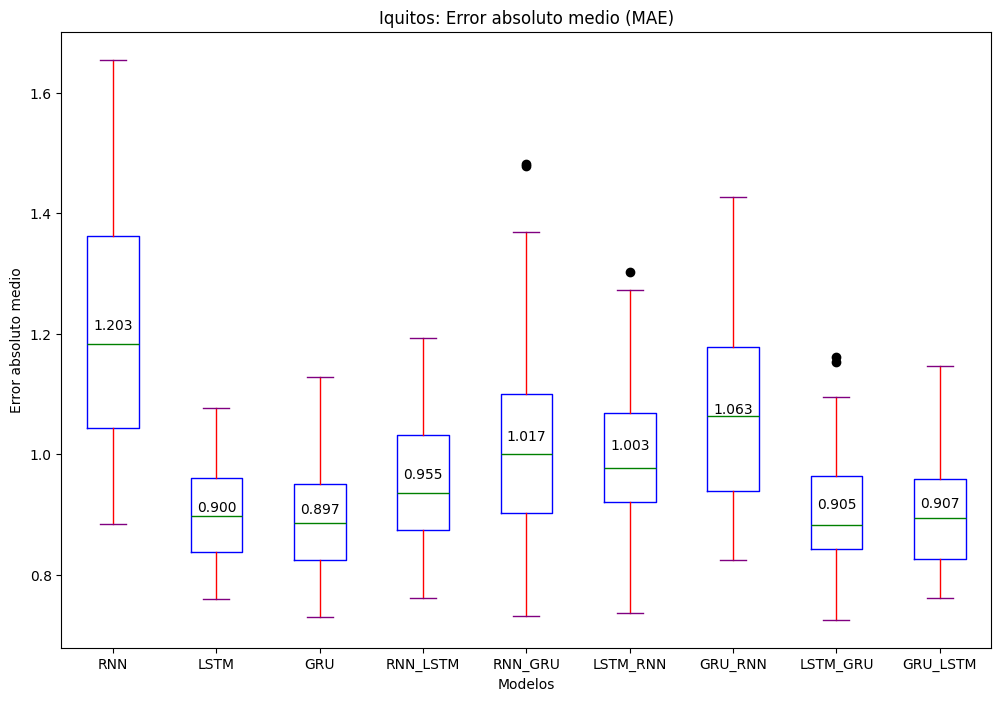

In [302]:
# n = int(len(df)*0.15)
n = int(len(df1) * 0.025)
print("Columns of df1:", df1.columns)
data = pd.DataFrame({
    'RNN': sorted(df1[0]),
    'LSTM': sorted(df2[0]),
    'GRU': sorted(df3[0]),
    'RNN_LSTM': sorted(df4[0]),
    'RNN_GRU': sorted(df5[0]),
    'LSTM_RNN': sorted(df6[0]),
    'GRU_RNN': sorted(df7[0]),
    'LSTM_GRU': sorted(df8[0]),
    'GRU_LSTM': sorted(df9[0])
}).iloc[n:-n]

box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error absoluto medio (MAE)')
plt.xlabel('Modelos')
plt.ylabel('Error absoluto medio')
files.download("Comparison_MAE_Dataset2.pdf")
plt.show()

In [288]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results_mae = {}
for column in data.columns:
    mean_mae = np.mean(data[column])
    std_mae = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n_mae = len(data[column])
    if n_mae > 1:
        t_score_mae = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval_mae = t_score_mae * (std_mae / np.sqrt(n_mae))
    else:
        confidence_interval_mae = float('nan') # Cannot calculate CI with only one data point

    results_mae[column] = {
        'Mean MAE': mean_mae,
        'Confidence Interval (95%)': confidence_interval_mae
    }

# Create a pandas DataFrame from the results
results_mae_df = pd.DataFrame.from_dict(results_mae, orient='index')

# Display the table
display(results_mae_df)

Mean MAE  Confidence Interval (95%)
RNN       1.202724                   0.041544
LSTM      0.900500                   0.016226
GRU       0.897113                   0.019570
RNN_LSTM  0.954771                   0.022731
RNN_GRU   1.017218                   0.031613
LSTM_RNN  1.003115                   0.023514
GRU_RNN   1.063086                   0.028703
LSTM_GRU  0.904595                   0.019233
GRU_LSTM  0.906834                   0.019136

**RMSE**

In [303]:
df1 = pd.read_excel('/content/RNN_FORECASTRMse.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTRMse.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTRMse.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_FORECASTRMse.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_FORECASTRMse.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_FORECASTRMse.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_FORECASTRMse.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_FORECASTRMse.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_FORECASTRMse.xlsx')
df = pd.DataFrame()
df['RNN'] = df1['RMSE']
df['LSTM'] = df2['RMSE']
df['GRU'] = df3['RMSE']
df['RNN_LSTM'] = df4['RMSE']
df['RNN_GRU'] = df5['RMSE']
df['LSTM_RNN'] = df6['RMSE']
df['GRU_RNN'] = df7['RMSE']
df['LSTM_GRU'] = df8['RMSE']
df['GRU_LSTM'] = df9['RMSE']
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

/tmp/ipython-input-2006042335.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

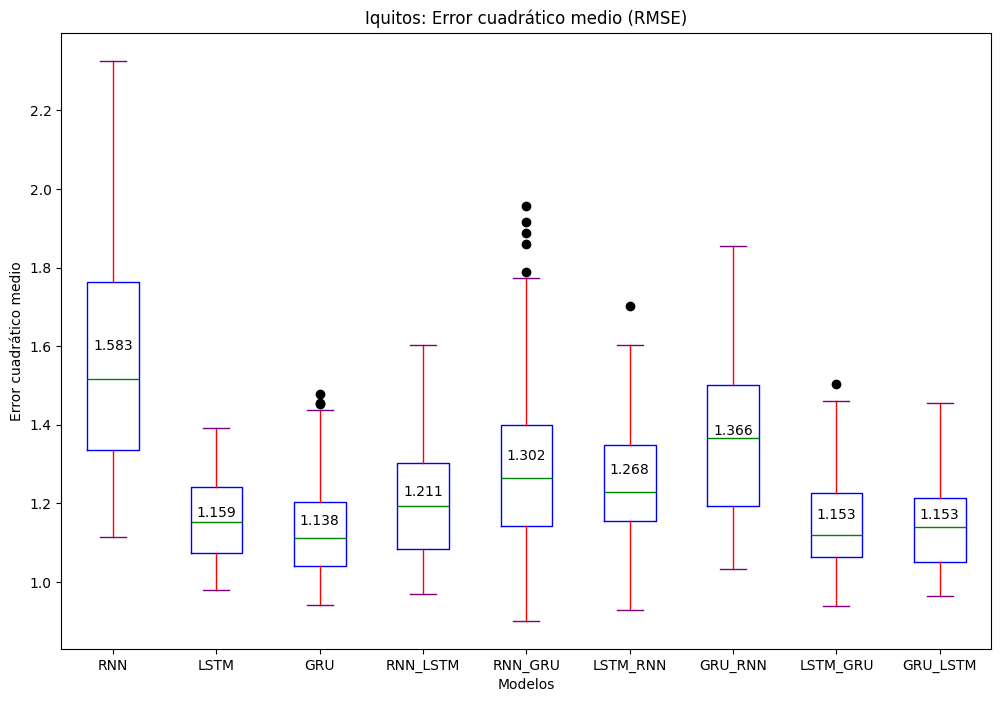

In [305]:
df = pd.DataFrame()
df['RNN'] = sorted(df1['RMSE'])
df['LSTM'] = sorted(df2['RMSE'])
df['GRU'] = sorted(df3['RMSE'])
df['RNN_LSTM'] = sorted(df4['RMSE'])
df['RNN_GRU'] = sorted(df5['RMSE'])
df['LSTM_RNN'] = sorted(df6['RMSE'])
df['GRU_RNN'] = sorted(df7['RMSE'])
df['LSTM_GRU'] = sorted(df8['RMSE'])
df['GRU_LSTM'] = sorted(df9['RMSE'])
# n = int(len(df)*0.15)
n = int(len(df) * 0.025)

df = df[:].iloc[n:-n]
data = df[:]
box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error cuadrático medio (RMSE)')
plt.xlabel('Modelos')
plt.ylabel('Error cuadrático medio')
plt.savefig("Comparison_RMSE_Dataset2.pdf", dpi=300)
files.download("Comparison_RMSE_Dataset2.pdf")
plt.show()

In [291]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results_rmse = {}
for column in data.columns:
    mean_rmse = np.mean(data[column])
    std_rmse = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n_rmse = len(data[column])
    if n_rmse > 1:
        t_score_rmse = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval_rmse = t_score_rmse * (std_rmse / np.sqrt(n_rmse))
    else:
        confidence_interval_rmse = float('nan') # Cannot calculate CI with only one data point

    results_rmse[column] = {
        'Mean RMSE': mean_rmse,
        'Confidence Interval (95%)': confidence_interval_rmse
    }

# Create a pandas DataFrame from the results
results_rmse_df = pd.DataFrame.from_dict(results_rmse, orient='index')

# Display the table
display(results_rmse_df)

Mean RMSE  Confidence Interval (95%)
RNN        1.583027                   0.062560
LSTM       1.158956                   0.022213
GRU        1.137994                   0.027276
RNN_LSTM   1.211459                   0.032226
RNN_GRU    1.302358                   0.044888
LSTM_RNN   1.267636                   0.031340
GRU_RNN    1.366056                   0.039983
LSTM_GRU   1.152648                   0.025810
GRU_LSTM   1.152763                   0.026020

**MAPE**

In [306]:
df1 = pd.read_excel('/content/RNN_FORECASTMpe.xlsx')
df2 = pd.read_excel('/content/LSTM_FORECASTMpe.xlsx')
df3 = pd.read_excel('/content/GRU_FORECASTMpe.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_FORECASTMpe.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_FORECASTMpe.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_FORECASTMpe.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_FORECASTMpe.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_FORECASTMpe.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_FORECASTMpe.xlsx')
df = pd.DataFrame()
df['RNN'] = df1['MAPE']
df['LSTM'] = df2['MAPE']
df['GRU'] = df3['MAPE']
df['RNN_LSTM'] = df4['MAPE']
df['RNN_GRU'] = df5['MAPE']
df['LSTM_RNN'] = df6['MAPE']
df['GRU_RNN'] = df7['MAPE']
df['LSTM_GRU'] = df8['MAPE']
df['GRU_LSTM'] = df9['MAPE']
# n = int(len(df) * (20 / 100))
n = int(len(df) * (2.5 / 100))
df = df.iloc[n:-n]

/tmp/ipython-input-1016891737.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data.values, labels=data.columns,


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

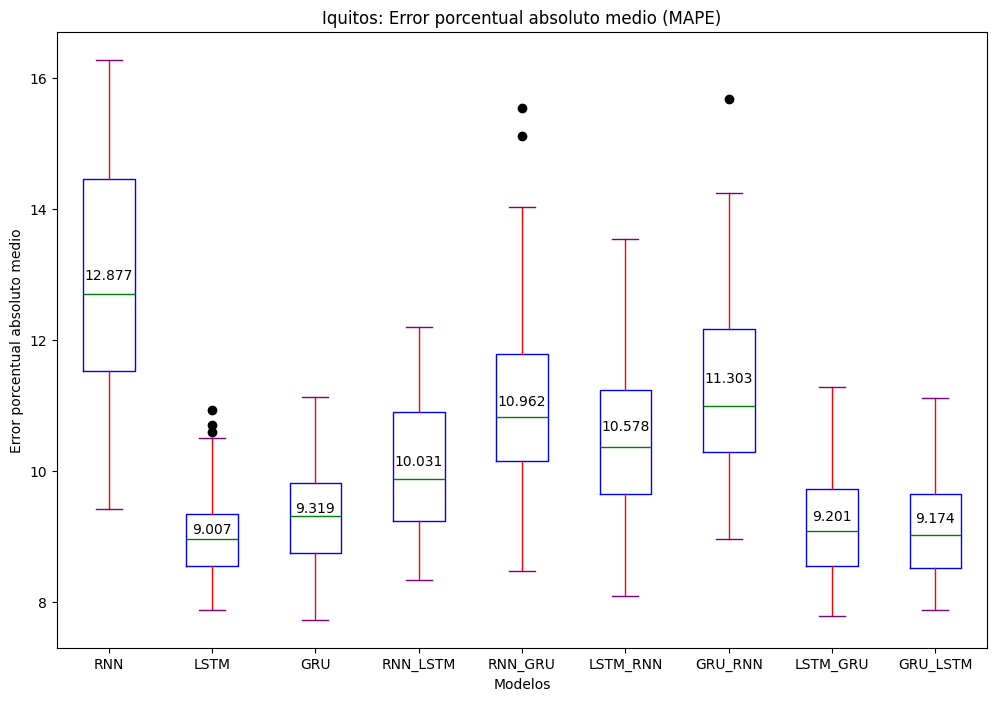

In [307]:
df = pd.DataFrame()
df['RNN'] = sorted(df1['MAPE'])
df['LSTM'] = sorted(df2['MAPE'])
df['GRU'] = sorted(df3['MAPE'])
df['RNN_LSTM'] = sorted(df4['MAPE'])
df['RNN_GRU'] = sorted(df5['MAPE'])
df['LSTM_RNN'] = sorted(df6['MAPE'])
df['GRU_RNN'] = sorted(df7['MAPE'])
df['LSTM_GRU'] = sorted(df8['MAPE'])
df['GRU_LSTM'] = sorted(df9['MAPE'])
# n = int(len(df)*0.15)
n = int(len(df) * 0.025)
df = df[:].iloc[n:-n]
data = df[:]
box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'
fig, ax = plt.subplots(figsize=(12, 8))
plt.boxplot(data.values, labels=data.columns,
boxprops=dict(color=box_color),
whiskerprops=dict(color=whisker_color),
capprops=dict(color=cap_color),
flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
medianprops=dict(color=median_color))
for i, column in enumerate(data.columns):
    mean = np.mean(data[column])
    plt.text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
plt.title('Iquitos: Error porcentual absoluto medio (MAPE)')
plt.xlabel('Modelos')
plt.ylabel('Error porcentual absoluto medio')
plt.savefig("Comparison_MAPE_Dataset2.pdf", dpi=300)
files.download("Comparison_MAPE_Dataset2.pdf")
plt.show()

In [294]:
# Calculate mean and confidence intervals for each model (using a 95% confidence level) based on filtered data
results = {}
for column in data.columns:
    mean = np.mean(data[column])
    std = np.std(data[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n = len(data[column])
    if n > 1:
        t_score = 2.0 # Approximate t-score for 95% CI and reasonable df, more precise calculation is possible with scipy.stats.t.ppf
        confidence_interval = t_score * (std / np.sqrt(n))
    else:
        confidence_interval = float('nan') # Cannot calculate CI with only one data point

    results[column] = {
        'Mean MAPE': mean,
        'Confidence Interval (95%)': confidence_interval
    }

# Create a pandas DataFrame from the results
results_df = pd.DataFrame.from_dict(results, orient='index')

# Display the table
display(results_df)

Mean MAPE  Confidence Interval (95%)
RNN       12.877303                   0.345510
LSTM       9.007143                   0.134721
GRU        9.318913                   0.162421
RNN_LSTM  10.031364                   0.201988
RNN_GRU   10.961641                   0.269057
LSTM_RNN  10.578385                   0.250069
GRU_RNN   11.303481                   0.274403
LSTM_GRU   9.201300                   0.169939
GRU_LSTM   9.174110                   0.159279

**Time Comparison**

/tmp/ipython-input-1355163328.py:86: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(data_mae.values, labels=data_mae.columns,
/tmp/ipython-input-1355163328.py:102: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(data_rmse.values, labels=data_rmse.columns,
/tmp/ipython-input-1355163328.py:119: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[2].boxplot(data_mape.values, labels=data_mape.columns,


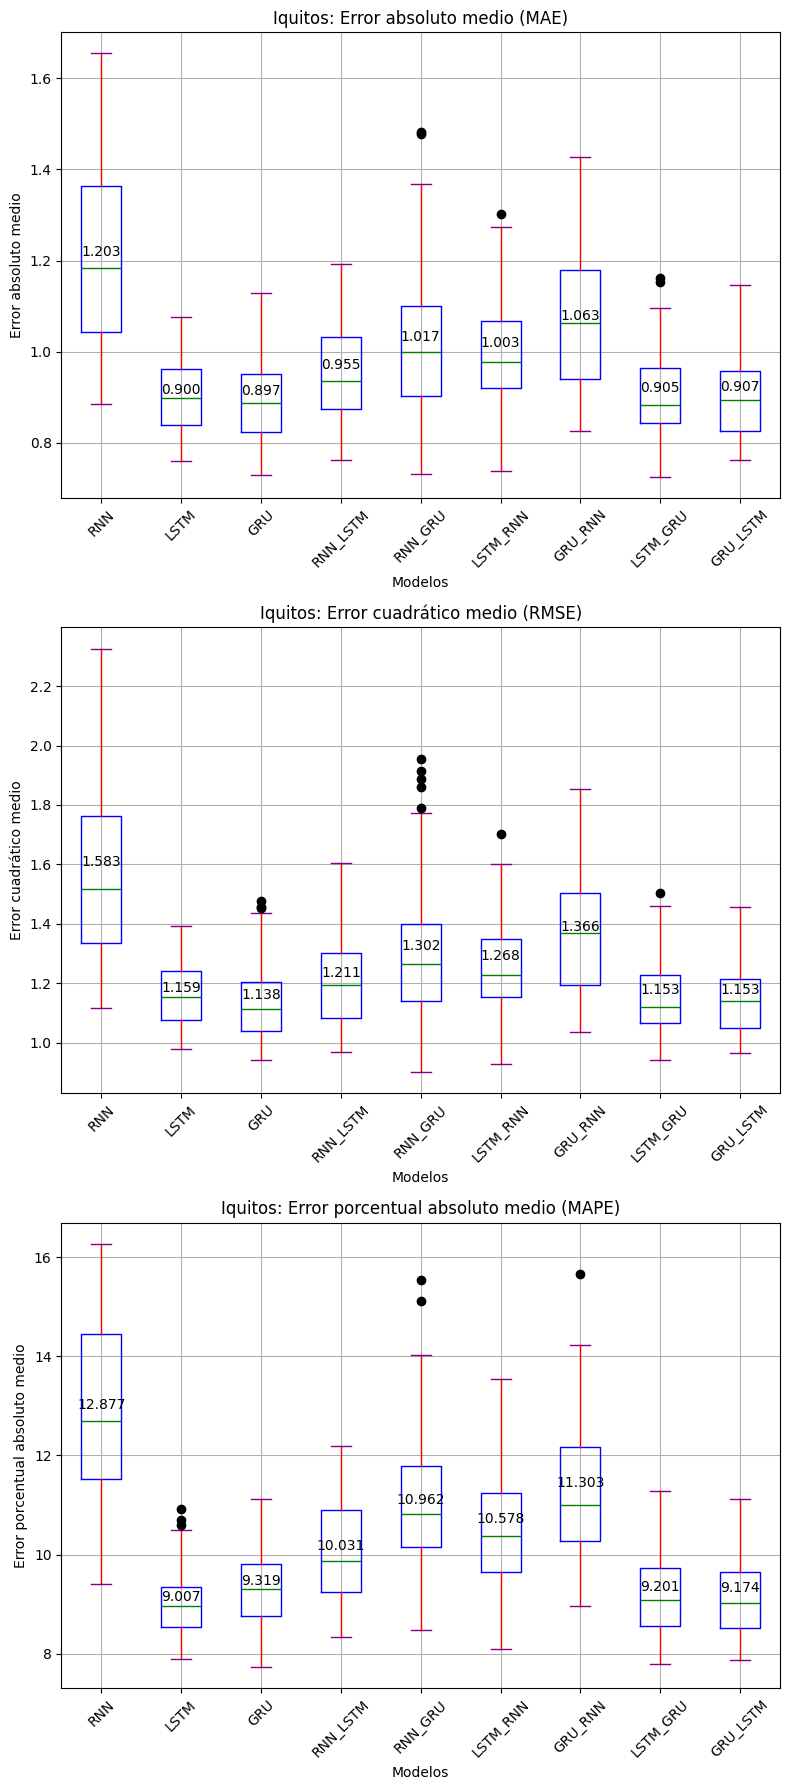

In [311]:
fig, axes = plt.subplots(3, 1, figsize=(8, 18))

# Load data for each metric
df_mae_1 = pd.read_excel('/content/RNN_FORECASTMae.xlsx')
df_mae_2 = pd.read_excel('/content/LSTM_FORECASTMae.xlsx')
df_mae_3 = pd.read_excel('/content/GRU_FORECASTMae.xlsx')
df_mae_4 = pd.read_excel('/content/RNN_LSTM_FORECASTMae.xlsx')
df_mae_5 = pd.read_excel('/content/RNN_GRU_FORECASTMae.xlsx')
df_mae_6 = pd.read_excel('/content/LSTM_RNN_FORECASTMae.xlsx')
df_mae_7 = pd.read_excel('/content/GRU_RNN_FORECASTMae.xlsx')
df_mae_8 = pd.read_excel('/content/LSTM_GRU_FORECASTMae.xlsx')
df_mae_9 = pd.read_excel('/content/GRU_LSTM_FORECASTMae.xlsx')

data_mae = pd.DataFrame({
    'RNN': sorted(df_mae_1[0]),
    'LSTM': sorted(df_mae_2[0]),
    'GRU': sorted(df_mae_3[0]),
    'RNN_LSTM': sorted(df_mae_4[0]),
    'RNN_GRU': sorted(df_mae_5[0]),
    'LSTM_RNN': sorted(df_mae_6[0]),
    'GRU_RNN': sorted(df_mae_7[0]),
    'LSTM_GRU': sorted(df_mae_8[0]),
    'GRU_LSTM': sorted(df_mae_9[0])
})
n_mae = int(len(data_mae) * 0.025)
data_mae = data_mae.iloc[n_mae:-n_mae]


df_rmse_1 = pd.read_excel('/content/RNN_FORECASTRMse.xlsx')
df_rmse_2 = pd.read_excel('/content/LSTM_FORECASTRMse.xlsx')
df_rmse_3 = pd.read_excel('/content/GRU_FORECASTRMse.xlsx')
df_rmse_4 = pd.read_excel('/content/RNN-LSTM_FORECASTRMse.xlsx')
df_rmse_5 = pd.read_excel('/content/RNN-GRU_FORECASTRMse.xlsx')
df_rmse_6 = pd.read_excel('/content/LSTM-RNN_FORECASTRMse.xlsx')
df_rmse_7 = pd.read_excel('/content/GRU-RNN_FORECASTRMse.xlsx')
df_rmse_8 = pd.read_excel('/content/LSTM-GRU_FORECASTRMse.xlsx')
df_rmse_9 = pd.read_excel('/content/GRU-LSTM_FORECASTRMse.xlsx')

data_rmse = pd.DataFrame({
    'RNN': sorted(df_rmse_1['RMSE']),
    'LSTM': sorted(df_rmse_2['RMSE']),
    'GRU': sorted(df_rmse_3['RMSE']),
    'RNN_LSTM': sorted(df_rmse_4['RMSE']),
    'RNN_GRU': sorted(df_rmse_5['RMSE']),
    'LSTM_RNN': sorted(df_rmse_6['RMSE']),
    'GRU_RNN': sorted(df_rmse_7['RMSE']),
    'LSTM_GRU': sorted(df_rmse_8['RMSE']),
    'GRU_LSTM': sorted(df_rmse_9['RMSE'])
})
n_rmse = int(len(data_rmse) * 0.025)
data_rmse = data_rmse.iloc[n_rmse:-n_rmse]


df_mape_1 = pd.read_excel('/content/RNN_FORECASTMpe.xlsx')
df_mape_2 = pd.read_excel('/content/LSTM_FORECASTMpe.xlsx')
df_mape_3 = pd.read_excel('/content/GRU_FORECASTMpe.xlsx')
df_mape_4 = pd.read_excel('/content/RNN-LSTM_FORECASTMpe.xlsx')
df_mape_5 = pd.read_excel('/content/RNN-GRU_FORECASTMpe.xlsx')
df_mape_6 = pd.read_excel('/content/LSTM-RNN_FORECASTMpe.xlsx')
df_mape_7 = pd.read_excel('/content/GRU-RNN_FORECASTMpe.xlsx')
df_mape_8 = pd.read_excel('/content/LSTM-GRU_FORECASTMpe.xlsx')
df_mape_9 = pd.read_excel('/content/GRU-LSTM_FORECASTMpe.xlsx')

data_mape = pd.DataFrame({
    'RNN': sorted(df_mape_1['MAPE']),
    'LSTM': sorted(df_mape_2['MAPE']),
    'GRU': sorted(df_mape_3['MAPE']),
    'RNN_LSTM': sorted(df_mape_4['MAPE']),
    'RNN_GRU': sorted(df_mape_5['MAPE']),
    'LSTM_RNN': sorted(df_mape_6['MAPE']),
    'GRU_RNN': sorted(df_mape_7['MAPE']),
    'LSTM_GRU': sorted(df_mape_8['MAPE']),
    'GRU_LSTM': sorted(df_mape_9['MAPE'])
})
n_mape = int(len(data_mape) * 0.025)
data_mape = data_mape.iloc[n_mape:-n_mape]


# MAE plot
box_color = 'blue'
whisker_color = 'red'
median_color = 'green'
flier_color = 'black'
cap_color = 'purple'

axes[0].boxplot(data_mae.values, labels=data_mae.columns,
            boxprops=dict(color=box_color),
            whiskerprops=dict(color=whisker_color),
            capprops=dict(color=cap_color),
            flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
            medianprops=dict(color=median_color))
for i, column in enumerate(data_mae.columns):
    mean = np.mean(data_mae[column])
    axes[0].text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
axes[0].set_title('Iquitos: Error absoluto medio (MAE)')
axes[0].set_xlabel('Modelos')
axes[0].set_ylabel('Error absoluto medio')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True)

# RMSE plot
axes[1].boxplot(data_rmse.values, labels=data_rmse.columns,
            boxprops=dict(color=box_color),
            whiskerprops=dict(color=whisker_color),
            capprops=dict(color=cap_color),
            flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
            medianprops=dict(color=median_color))
for i, column in enumerate(data_rmse.columns):
    mean = np.mean(data_rmse[column])
    axes[1].text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
axes[1].set_title('Iquitos: Error cuadrático medio (RMSE)')
axes[1].set_xlabel('Modelos')
axes[1].set_ylabel('Error cuadrático medio')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True)


# MAPE plot
axes[2].boxplot(data_mape.values, labels=data_mape.columns,
            boxprops=dict(color=box_color),
            whiskerprops=dict(color=whisker_color),
            capprops=dict(color=cap_color),
            flierprops=dict(markerfacecolor=flier_color, marker='o', markersize=6),
            medianprops=dict(color=median_color))
for i, column in enumerate(data_mape.columns):
    mean = np.mean(data_mape[column])
    axes[2].text(i + 1, mean, f'{mean:.3f}', ha='center', va='bottom', color='black')
axes[2].set_title('Iquitos: Error porcentual absoluto medio (MAPE)')
axes[2].set_xlabel('Modelos')
axes[2].set_ylabel('Error porcentual absoluto medio')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True)

plt.tight_layout()
plt.savefig('metricas_de_evaluacion.png', dpi=300)
plt.show()

In [297]:
df1 = pd.read_excel('/content/RNN_TIME.xlsx')
df2 = pd.read_excel('/content/LSTM_TIME.xlsx')
df3 = pd.read_excel('/content/GRU_TIME.xlsx')
df4 = pd.read_excel('/content/RNN-LSTM_TIME.xlsx')
df5 = pd.read_excel('/content/RNN-GRU_TIME.xlsx')
df6 = pd.read_excel('/content/LSTM-RNN_TIME.xlsx')
df7 = pd.read_excel('/content/GRU-RNN_TIME.xlsx')
df8 = pd.read_excel('/content/LSTM-GRU_TIME.xlsx')
df9 = pd.read_excel('/content/GRU-LSTM_TIME.xlsx')
df = pd.DataFrame()
df['RNN'] = df1[0]
df['LSTM'] = df2[0]
df['GRU'] = df3[0]
df['RNN_LSTM'] = df4[0]
df['RNN_GRU'] = df5[0]
df['LSTM_RNN'] = df6[0]
df['GRU_RNN'] = df7[0]
df['LSTM_GRU'] = df8[0]
df['GRU_LSTM'] = df9[0]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

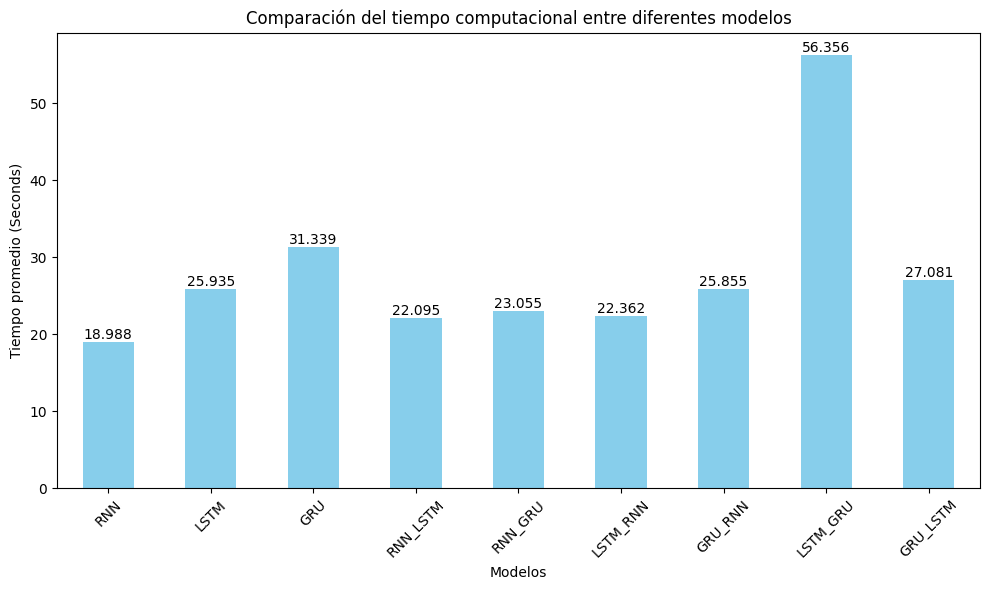

In [298]:
# Calculate the average time for each model
average_times = df.mean()
# Create a bar chart
plt.figure(figsize=(10, 6))
average_times.plot(kind='bar', color='skyblue')
plt.title('Comparación del tiempo computacional entre diferentes modelos')
plt.xlabel('Modelos')
plt.ylabel('Tiempo promedio (Seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
# Display the average times on top of the bars
for i, v in enumerate(average_times):
    plt.text(i, v, f"{v:.3f}", ha='center', va='bottom')
plt.savefig("Comparison_Time_Dataset2.pdf", dpi=300)
files.download("Comparison_Time_Dataset2.pdf")
plt.show()

In [299]:
# Calculate mean and confidence intervals for training time for each model (using a 95% confidence level)
results_time = {}
for column in df.columns:
    mean_time = np.mean(df[column])
    std_time = np.std(df[column])
    # Calculate 95% confidence interval (using t-distribution for small sample sizes)
    # Degrees of freedom is n-1
    n_time = len(df[column])
    if n_time > 1:
        # Using a t-score of 2.0 as an approximation for 95% CI with reasonable degrees of freedom
        t_score_time = 2.0
        confidence_interval_time = t_score_time * (std_time / np.sqrt(n_time))
    else:
        confidence_interval_time = float('nan') # Cannot calculate CI with only one data point

    results_time[column] = {
        'Mean Training Time (s)': mean_time,
        'Confidence Interval (95%) (s)': confidence_interval_time
    }

# Create a pandas DataFrame from the results
results_time_df = pd.DataFrame.from_dict(results_time, orient='index')

# Display the table
display(results_time_df)

Mean Training Time (s)  Confidence Interval (95%) (s)
RNN                    18.988155                       1.844767
LSTM                   25.935387                       0.466683
GRU                    31.338742                       3.362538
RNN_LSTM               22.094722                       0.204932
RNN_GRU                23.054897                       0.132020
LSTM_RNN               22.362013                       0.086299
GRU_RNN                25.855054                       0.122684
LSTM_GRU               56.355935                      13.201477
GRU_LSTM               27.080903                       0.152735

In [273]:
# Define a function to categorize models based on a metric's mean values
def categorize_performance(mean_values, metric_name):
    sorted_means = mean_values.sort_values()
    n_models = len(sorted_means)
    categories = {}

    for i, (model_name, mean_value) in enumerate(sorted_means.items()):
        # Define thresholds based on relative ranking or percentiles
        # These thresholds can be adjusted based on desired granularity
        if i < int(0.15 * n_models): # Top 15%
            category = 'Excelente'
        elif i < int(0.40 * n_models): # Next 25%
            category = 'Mejor'
        elif i < int(0.60 * n_models): # Middle 20%
            category = 'Bien'
        elif i < int(0.85 * n_models): # Next 25%
            category = 'Por debajo del promedio'
        else: # Bottom 15%
            category = 'Pobre'
        categories[model_name] = category
    return categories

# Get the mean values for each metric
mean_mae = results_mae_df['Mean MAE']
mean_rmse = results_rmse_df['Mean RMSE']
mean_mape = results_df['Mean MAPE']

# Categorize models for each metric
mae_categories = categorize_performance(mean_mae, 'MAE')
rmse_categories = categorize_performance(mean_rmse, 'RMSE')
mape_categories = categorize_performance(mean_mape, 'MAPE')

# Create a DataFrame to display the categorized results
categorized_results_df = pd.DataFrame({
    'Categoría MAE': pd.Series(mae_categories),
    'Categoría RMSE': pd.Series(rmse_categories),
    'Categoría MAPE': pd.Series(mape_categories)
})

# Display the table
display(categorized_results_df)

Categoría MAE           Categoría RMSE  \
GRU                     Excelente                Excelente   
GRU_LSTM                     Bien                    Mejor   
GRU_RNN                     Pobre                    Pobre   
LSTM                        Mejor                     Bien   
LSTM_GRU                    Mejor                    Mejor   
LSTM_RNN  Por debajo del promedio  Por debajo del promedio   
RNN                         Pobre                    Pobre   
RNN_GRU   Por debajo del promedio  Por debajo del promedio   
RNN_LSTM                     Bien                     Bien   

                   Categoría MAPE  
GRU                          Bien  
GRU_LSTM                    Mejor  
GRU_RNN                     Pobre  
LSTM                    Excelente  
LSTM_GRU                    Mejor  
LSTM_RNN  Por debajo del promedio  
RNN                         Pobre  
RNN_GRU   Por debajo del promedio  
RNN_LSTM                     Bien

In [274]:
# Calculate ranks for each metric (lower is better, so rank 1 is the lowest value)
# Using method='min' to assign the minimum rank to ties
ranks_mae = results_mae_df['Mean MAE'].rank(method='min')
ranks_rmse = results_rmse_df['Mean RMSE'].rank(method='min')
ranks_mape = results_df['Mean MAPE'].rank(method='min')

# Combine ranks into a single DataFrame
combined_ranks = pd.DataFrame({
    'Rank MAE': ranks_mae,
    'Rank RMSE': ranks_rmse,
    'Rank MAPE': ranks_mape
})

# Calculate the Mean Rank across the three metrics
combined_ranks['Mean Rank'] = combined_ranks[['Rank MAE', 'Rank RMSE', 'Rank MAPE']].mean(axis=1)

# Sort models by Mean Rank (lower Mean Rank is better)
ranked_models = combined_ranks.sort_values(by='Mean Rank')

# Define performance categories based on Mean Rank
# Using relative ranking (percentiles) similar to the previous categorization
n_models = len(ranked_models)
performance_levels = []
for i, (model_name, row) in enumerate(ranked_models.iterrows()):
    mean_rank = row['Mean Rank']
    if i < int(0.15 * n_models):
        level = 'Excelente' # Top 15% Mean Rank
    elif i < int(0.40 * n_models):
        level = 'Mejor' # Next 25% Mean Rank
    elif i < int(0.60 * n_models):
        level = 'Bien' # Middle 20% Mean Rank
    elif i < int(0.85 * n_models):
        level = 'Por debajo del promedio' # Next 25% Mean Rank
    else:
        level = 'Pobre' # Bottom 15% Mean Rank
    performance_levels.append(level)

# Add the Performance Level category to the ranked models DataFrame
ranked_models['Nivel de rendimiento'] = performance_levels

# Display the table with Mean Rank and Performance Level
display(ranked_models)

Rank MAE  Rank RMSE  Rank MAPE  Mean Rank     Nivel de rendimiento
GRU            1.0        1.0        4.0   2.000000                Excelente
LSTM           2.0        4.0        1.0   2.333333                    Mejor
LSTM_GRU       3.0        2.0        3.0   2.666667                    Mejor
GRU_LSTM       4.0        3.0        2.0   3.000000                     Bien
RNN_LSTM       5.0        5.0        5.0   5.000000                     Bien
LSTM_RNN       6.0        6.0        6.0   6.000000  Por debajo del promedio
RNN_GRU        7.0        7.0        7.0   7.000000  Por debajo del promedio
GRU_RNN        8.0        8.0        8.0   8.000000                    Pobre
RNN            9.0        9.0        9.0   9.000000                    Pobre